## ADM Assignment 5 
### Network Scholar: Graph-Based Analysis and Visualization of Academic Collaborations

### Libraries 


In [82]:
import pandas as pd
import numpy as np
import ijson
import time
import networkx as nx
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import math
import seaborn as sns
from nltk.stem import *
import nltk
from nltk.corpus import stopwords
import random
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hazem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hazem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### A script to convert the data from JSON to a PD dataframe 
##### Reference: https://www.kaggle.com/code/devintheai/citation-network-eda

In [19]:
papers = []

start = time.process_time()

with open('citation.json', "rb") as f:
    for i, element in enumerate(ijson.items(f, "item")):
        paper = {}
        paper['id'] = element['id']
        paper['title'] = element['title']

        author = element.get('authors')
        if author:
            Author = element['authors']
            author_name = []
            author_id = []

            for j in Author:
                if 'name' in j and 'id' in j :
                    author_name.append(str(j['name']))  
                    author_id.append(str(j['id']))
                else:
                    author_name.append(str(np.nan))  
                    author_id.append(str(np.nan))

            paper['author_name'] = ';'.join(author_name)
            paper['author_id'] = ';'.join(author_id)
        
        year = element.get('year')
        if year:
            paper['year']= year
        else:
            paper['year']= np.nan
        
        n_citation= element.get('n_citation')
        if n_citation:
             paper['n_citation']= element['n_citation']
        else:
            paper['n_citation']= 0
        
        doc_type= element.get('doc_type') 
        if doc_type:
            paper['doc_type']= element['doc_type']
        else:
            paper['doc_type']= np.nan   

        references= element.get('references')
        if references:
            paper['reference_count']= len(references)
            # joining all refs id in a `;` seperated string  
            paper['references']= ';'.join([str(int(r)) for r in references])
        else:
            paper['reference_count']= np.nan 
            paper['references']= np.nan
        
        doi = element.get('doi')
        if doi:
            paper['doi']= f"https://doi.org/{element['doi']}"
        else:
            paper['doi']= np.nan               
        
        
        papers.append(paper)
        
        if i%48000 == 0:
            print(f"{i}:{round((time.process_time() - start),2)}s ",end="")


0:0.0s 48000:2.09s 96000:4.16s 144000:5.89s 192000:7.84s 240000:9.44s 288000:11.86s 336000:14.5s 384000:17.28s 432000:20.17s 480000:22.84s 528000:25.45s 576000:28.28s 624000:30.64s 672000:33.3s 720000:36.08s 768000:38.66s 816000:41.33s 864000:44.41s 912000:46.8s 960000:49.05s 1008000:51.69s 1056000:54.25s 1104000:56.81s 1152000:59.5s 1200000:62.64s 1248000:65.91s 1296000:68.48s 1344000:71.47s 1392000:74.38s 1440000:77.31s 1488000:80.56s 1536000:83.39s 1584000:86.45s 1632000:89.52s 1680000:92.36s 1728000:95.06s 1776000:98.23s 1824000:100.75s 1872000:103.48s 1920000:106.33s 1968000:109.38s 2016000:112.3s 2064000:115.48s 2112000:118.41s 2160000:121.86s 2208000:125.41s 2256000:129.03s 2304000:132.39s 2352000:136.17s 2400000:139.7s 2448000:143.22s 2496000:146.95s 2544000:150.55s 2592000:154.06s 2640000:157.98s 2688000:161.62s 2736000:165.09s 2784000:168.62s 2832000:172.39s 2880000:176.22s 2928000:180.03s 2976000:183.92s 3024000:187.5s 3072000:190.84s 3120000:194.27s 3168000:196.94s 3216000:

- - - 
### 1. Data pre-processing

In [ ]:
df = pd.DataFrame(papers)
df.head()

In [22]:
print('There are', len(df),'papers in the dataset')

There are 4894081 papers in the dataset


#### Filtering the data to find the top 10000 papers

In [23]:
df = df.sort_values(by='n_citation', ascending=False)
df = df.head(10000).copy()
df.head()

,id,title,author_name,author_id,year,n_citation,doc_type,reference_count,references,doi
4696136,2041404167,The Mathematical Theory of Communication,C. E. Shannon,2247248564,1949.0,48327,Book,NaN,NaN,NaN
4630907,1639032689,"Genetic algorithms in search, optimization, an...",David E. Goldberg,2102678951,1989.0,44175,Book,NaN,NaN,NaN
4092588,2912565176,Fuzzy sets,Lotfi A. Zadeh,2252586558,1996.0,42437,NaN,NaN,NaN,NaN
2937610,2151103935,Distinctive Image Features from Scale-Invarian...,David G. Lowe,2104328312,2004.0,35541,Journal,33.0,19720318;1541642243;1560959218;1676552347;1681...,https://doi.org/10.1023/B:VISI.0000029664.9961...
4088311,2911964244,Random Forests,Leo Breiman,2569376642,2001.0,34741,NaN,11.0,1507255258;1580948147;1605688901;1975846642;20...,https://doi.org/10.1023/A:1010933404324


In [24]:
df.describe()

,id,year,n_citation,reference_count
count,1.000000e+04,10000.000000,10000.000000,8795.000000
mean,2.039274e+09,2000.128000,1451.995800,21.359068
std,3.103127e+08,10.066367,1954.416052,32.146003
min,8.528740e+05,1899.000000,596.000000,1.000000
25%,2.013153e+09,1996.000000,716.000000,7.000000
50%,2.106909e+09,2002.000000,924.000000,14.000000
75%,2.144150e+09,2007.000000,1421.000000,25.000000
max,3.003663e+09,2019.000000,48327.000000,1287.000000


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 4696136 to 2109151
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               10000 non-null  int64  
 1   title            10000 non-null  object 
 2   author_name      10000 non-null  object 
 3   author_id        10000 non-null  object 
 4   year             10000 non-null  float64
 5   n_citation       10000 non-null  int64  
 6   doc_type         9650 non-null   object 
 7   reference_count  8795 non-null   float64
 8   references       8795 non-null   object 
 9   doi              8451 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 859.4+ KB


In [26]:
# convert the year, n_citation, and reference_count columns to int
df['year'] = df['year'].astype('Int64')
df['n_citation'] = df['n_citation'].astype('Int64')
df['reference_count'] = df['reference_count'].astype('Int64')

In [247]:
# saving the dataframe to a csv file
df.to_csv('citation.csv', index=False)


In [183]:
df = pd.read_csv('citation.csv')
df.head(7)

,id,title,author_name,author_id,year,n_citation,doc_type,reference_count,references,doi
0,2041404167,The Mathematical Theory of Communication,C. E. Shannon,2247248564,1949,48327,Book,NaN,NaN,NaN
1,1639032689,"Genetic algorithms in search, optimization, an...",David E. Goldberg,2102678951,1989,44175,Book,NaN,NaN,NaN
2,2912565176,Fuzzy sets,Lotfi A. Zadeh,2252586558,1996,42437,NaN,NaN,NaN,NaN
3,2151103935,Distinctive Image Features from Scale-Invarian...,David G. Lowe,2104328312,2004,35541,Journal,33.0,19720318;1541642243;1560959218;1676552347;1681...,https://doi.org/10.1023/B:VISI.0000029664.9961...
4,2911964244,Random Forests,Leo Breiman,2569376642,2001,34741,NaN,11.0,1507255258;1580948147;1605688901;1975846642;20...,https://doi.org/10.1023/A:1010933404324
5,1973948212,Applied Logistic Regression,David W. Hosmer;Stanley Lemeshow,2102544963;1990110535,1989,32053,Book,NaN,NaN,NaN
6,2153635508,LIBSVM: A library for support vector machines,Chih-Chung Chang;Chih-Jen Lin,2895256545;2168176072,2011,31047,Journal,34.0,1510526001;1543810117;1556115774;1568793342;16...,https://doi.org/10.1145/1961189.1961199


#### Citation Graph

In [357]:
# create the citation graph
citation_graph = nx.DiGraph()

##### **Adding Nodes:** Each node in the graph will be identified by the paper ID and will have an attribute called title that has the paper's title 

In [358]:
# iterate through the dataframe rows
for index, row in df.iterrows():
    # getting the paper id and title
    paper_id = row['id']
    title = row['title']
    # make sure that the ID is not NaN
    if paper_id != 'nan' or paper_id != 'NaN' or paper_id != '':
        # add the node to the graph
        citation_graph.add_node(paper_id, title=title)

In [359]:
citation_graph.number_of_nodes()

10000

In [360]:
# first 10 nodes data in the citation graph
c = 0
for node, data in citation_graph.nodes(data=True):
    c += 1
    print(f"Node {node}: {data}")
    if c > 10:
        break

Node 2041404167: {'title': 'The Mathematical Theory of Communication'}
Node 1639032689: {'title': 'Genetic algorithms in search, optimization, and machine learning'}
Node 2912565176: {'title': 'Fuzzy sets'}
Node 2151103935: {'title': 'Distinctive Image Features from Scale-Invariant Keypoints'}
Node 2911964244: {'title': 'Random Forests'}
Node 1973948212: {'title': 'Applied Logistic Regression'}
Node 2153635508: {'title': 'LIBSVM: A library for support vector machines'}
Node 2156909104: {'title': 'The Nature of Statistical Learning Theory'}
Node 1791587663: {'title': 'Perceived usefulness, perceived ease of use, and user acceptance of information technology'}
Node 2119821739: {'title': 'Support-Vector Networks'}
Node 1995875735: {'title': 'A mathematical theory of communication'}


##### **Adding the Edges:** If paper A has cited paper B, an edge from node A to B is added.

In [361]:
# Iterate through the DataFrame rows
for index, row in df.iterrows():
    # Getting the paper id and references
    paper_id = row['id']
    references = row['references']

    references = str(references).split(';')
    # Make sure that the ID and references are not NaN
    if paper_id != 'nan' or paper_id != 'NaN' or paper_id != '':
        if references != 'nan' or references != 'NaN' or references != '':
            # Iterate through the references
            for reference in references:
                # Add an edge to the graph
                    citation_graph.add_edge(paper_id, reference)


##### Checking the correctness of the edges

In [362]:
# Node of interest
node_to_check = 2911964244

# Get the outgoing edges of the node
outgoing_edges = citation_graph.out_edges(node_to_check)

# Get the incoming edges of the node
incoming_edges = citation_graph.in_edges(node_to_check)

# Print the results
print(f"Outgoing edges of node {node_to_check}: {list(outgoing_edges)}")
print(f"Incoming edges of node {node_to_check}: {list(incoming_edges)}")

# references of the paper
references_list = df[df['id'] == node_to_check]['references'].values[0]
print(f"References of node {node_to_check}: {references_list}")



Outgoing edges of node 2911964244: [(2911964244, '1507255258'), (2911964244, '1580948147'), (2911964244, '1605688901'), (2911964244, '1975846642'), (2911964244, '2077200366'), (2911964244, '2099968818'), (2911964244, '2112076978'), (2911964244, '2113242816'), (2911964244, '2120240539'), (2911964244, '2152761983'), (2911964244, '2912934387')]
Incoming edges of node 2911964244: []
References of node 2911964244: 1507255258;1580948147;1605688901;1975846642;2077200366;2099968818;2112076978;2113242816;2120240539;2152761983;2912934387


The **references_list** and the **ougoing_edges** match which ensures the correctness of the graph.

In [363]:
# Save to GraphML
nx.write_gml(citation_graph, "citation_graph.gml")

#### Collaboration graph 

##### create a dictionary of authors and their IDs

In [5]:
# A dictionary to store authors and their IDs
authors_dict = dict()

# Iterate through the DataFrame rows
for index, row in df.iterrows():
    # Getting the author names and IDs
    author_names = row['author_name'].split(';')
    author_ids = row['author_id'].split(';')

    # Iterate through the authors and author IDs
    for author_name, author_id in zip(author_names, author_ids):
        # Update the authors_dict
        if author_id not in authors_dict:
            authors_dict[author_id] = []

        # Check for duplicates before appending to the list
        if author_name not in authors_dict[author_id]:
            authors_dict[author_id].append(author_name)

# removing the different versions of the names of the authors 
authors_dict = {key: values[0] for key, values in authors_dict.items()}


In [6]:
collab_graph = nx.Graph()

##### **Add the nodes to the graph:** the nodes are the authors' IDs and each node has the author's name as an attribute

In [7]:
# adding the nodes to the graph
for key, value in authors_dict.items():
    collab_graph.add_node(key, name=value)

In [8]:
# first 10 nodes data in the citation graph
c = 0
for node, data in collab_graph.nodes(data=True):
    c += 1
    print(f"Node {node}: {data}")
    if c > 10:
        break

Node 2247248564: {'name': 'C. E. Shannon'}
Node 2102678951: {'name': 'David E. Goldberg'}
Node 2252586558: {'name': 'Lotfi A. Zadeh'}
Node 2104328312: {'name': 'David G. Lowe'}
Node 2569376642: {'name': 'Leo Breiman'}
Node 2102544963: {'name': 'David W. Hosmer'}
Node 1990110535: {'name': 'Stanley Lemeshow'}
Node 2895256545: {'name': 'Chih-Chung Chang'}
Node 2168176072: {'name': 'Chih-Jen Lin'}
Node 2022407533: {'name': 'Vladimir N. Vapnik'}
Node 2427477170: {'name': 'Fred D. Davis'}


##### Generating a matrix to track the collaborative efforts of authors, where the frequency will serve as the weight for the graph.


In [9]:
matrix = pd.DataFrame(columns=authors_dict.keys(), index=authors_dict.keys())
# Set all values to empty lists
for col in matrix.columns:
    matrix[col] = [[] for _ in matrix.index]
matrix.head()

,2247248564,2102678951,2252586558,2104328312,2569376642,2102544963,1990110535,2895256545,2168176072,2022407533,...,176466469,2344230363,469273356,2477509334,2257320792,2119171673,2973489965,1974600515,299775663,282527274
2247248564,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
2102678951,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
2252586558,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
2104328312,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
2569376642,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]


In [15]:
for index, row in matrix.iterrows():
    # Get the author ID
    author_id = index
    
    # Get the author papers
    for index_df, row_df in df.iterrows():
        # Get the author IDs of the paper
        IDs = row_df['author_id'].split(';')
        paper_id = row_df['id']
        
        
        # Check if the author ID is in the IDs list
        if author_id in IDs:
            # Iterate through the IDs
            for ID in IDs:
                # Check if the author ID is not the same as the ID in the loop
                if ID != author_id:
                    # Append the paper ID
                    matrix.loc[author_id, ID].append(paper_id)

In [16]:
matrix.head()

,2247248564,2102678951,2252586558,2104328312,2569376642,2102544963,1990110535,2895256545,2168176072,2022407533,...,176466469,2344230363,469273356,2477509334,2257320792,2119171673,2973489965,1974600515,299775663,282527274
2247248564,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
2102678951,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
2252586558,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
2104328312,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
2569376642,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]


In [22]:
matrix.to_csv('collaboration.csv', index=False)

##### Creating the edges and assigning the weights based on the matrix 

In [19]:
# adding the edges to the graph
for index in matrix.index:
    for column in matrix.columns:
        # check if the weight is more than zero and the edge does nto exist
        if matrix.loc[index, column] != [] and not collab_graph.has_edge(index, column):
            collab_graph.add_edge(index, column, weight= len(matrix.loc[index, column]), papers_coauthored = matrix.loc[index, column])

In [22]:
# checking the first 20 edges of the graph
c = 0
for edge in collab_graph.edges(data=True):
    c += 1
    print(edge)
    if c > 20:
        break

('2102678951', '2150011549', {'weight': 3, 'papers_coauthored': [1568834902, 1606791384, 1572960541]})
('2102678951', '2289349322', {'weight': 1, 'papers_coauthored': [1905847227]})
('2102678951', '2967430569', {'weight': 1, 'papers_coauthored': [1905847227]})
('2102678951', '2112870757', {'weight': 2, 'papers_coauthored': [1541288193, 2103537992]})
('2102678951', '2281157639', {'weight': 1, 'papers_coauthored': [2126926002]})
('2102678951', '1996855907', {'weight': 1, 'papers_coauthored': [1606791384]})
('2102678951', '2010224735', {'weight': 1, 'papers_coauthored': [2170539222]})
('2102678951', '2250828903', {'weight': 2, 'papers_coauthored': [2170539222, 2148379945]})
('2102678951', '2700242703', {'weight': 1, 'papers_coauthored': [2103537992]})
('2102678951', '2503678005', {'weight': 1, 'papers_coauthored': [2148379945]})
('2252586558', '244126243', {'weight': 1, 'papers_coauthored': [2041064082]})
('2252586558', '2920276700', {'weight': 1, 'papers_coauthored': [2041064082]})
('210

In [24]:
# Save to gml
nx.write_gml(collab_graph, "collab_graph.gml")

In [27]:
collab_graph.number_of_nodes()

21235

In [28]:
# example of a node in the collaboration graph
node_to_check = '2150011549'
collab_graph.edges(node_to_check, data=True)

EdgeDataView([('2150011549', '2102678951', {'weight': 3, 'papers_coauthored': [1568834902, 1606791384, 1572960541]}), ('2150011549', '2120996014', {'weight': 2, 'papers_coauthored': [2126105956, '2167159964']}), ('2150011549', '2175835430', {'weight': 1, 'papers_coauthored': [2126105956]}), ('2150011549', '1208012566', {'weight': 2, 'papers_coauthored': [2126105956, '2167159964']}), ('2150011549', '177795906', {'weight': 2, 'papers_coauthored': [2125899728, 2063375245]}), ('2150011549', '2156635946', {'weight': 2, 'papers_coauthored': [2125899728, 2063375245]}), ('2150011549', '2467761819', {'weight': 1, 'papers_coauthored': [2116661285]}), ('2150011549', '2096079875', {'weight': 1, 'papers_coauthored': ['2167159964']}), ('2150011549', '2069070276', {'weight': 1, 'papers_coauthored': [2063375245]}), ('2150011549', '2641050018', {'weight': 1, 'papers_coauthored': [225560312]}), ('2150011549', '2423330096', {'weight': 1, 'papers_coauthored': [2022485595]}), ('2150011549', '1996855907', {

### 2.1. Backend Implementation
---

In [ ]:
# Load graphs from GraphML
citation_graph = nx.read_graphml("citation_graph.graphml")
collab_graph = nx.read_graphml("collab_graph.graphml")

#### Functionality 1 - Graph's features
This function should examine a graph and report on some of its features. The input and report that this function should produce are shown below. 

Input: 
- The graph
- The name of the graph

Output: 
- The number of the nodes in the graph
- The number of the edges in the graph
- The graph density
- The graph degree distribution
- The average degree of the graph
- The graph hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
- Whether the graph is dense or sparse


In [ ]:
def f1_graph_features(graph, name_of_graph):
    # The number of the nodes in the graph
    num_nodes = graph.number_of_nodes() 
    
    # The number of the edges in the graph
    num_edges = graph.number_of_edges() 
    
    # The graph density
    density = nx.density(graph)
    
    # The graph degree distribution
    degrees = sorted([d for n, d in graph.degree()], reverse=True)
    
    # The average degree of the graph
    average_degree = sum(degrees)/len(degrees)
    
    # The graph hubs
    ## Identifying 95th percentile
    percentile_95 = np.percentile(degrees, 95)
    hubs = [n for n, d in graph.degree() if d > percentile_95]

    # Whether the graph is dense or sparse
    # If density > 0.5 then isDense is True, else False
    isDense = True if density > 0.5 else False         
    
    return num_nodes, num_edges, density, degrees, average_degree, hubs, isDense    

In [ ]:
collab_num_nodes, collab_num_edges, collab_density, collab_degrees, collab_avg_degree, collab_hubs, collab_isDense  = f1_graph_features(collab_graph, 'collaboration graph')

In [ ]:
collab_num_nodes, collab_num_edges, collab_density, collab_avg_degree, collab_isDense

(21235, 136478, 0.0006053528157956642, 12.854061690605134, False)

In [ ]:
collab_degrees[:10]

[347, 326, 304, 296, 284, 284, 282, 279, 278, 276]

In [ ]:
collab_hubs[:10]

['1445484688',
 '2104401652',
 '2435751034',
 '2007415138',
 '2096217197',
 '2146468246',
 '215131072',
 '2429370538',
 '2575315241',
 '1822555116']

In [ ]:
citation_num_nodes, citation_num_edges, citation_density, citation_degrees, citation_avg_degree, citation_hubs, citation_isDense  = f1_graph_features(citation_graph, 'citation graph')

In [ ]:
citation_num_nodes, citation_num_edges, citation_density, citation_avg_degree, citation_isDense

(18780, 10000, 2.835515006934819e-05, 1.0649627263045793, False)

In [ ]:
citation_degrees[:10]

[1205, 3, 2, 2, 2, 2, 2, 2, 2, 2]

In [ ]:
citation_hubs

['nan',
 '[2022772618, 2026258334, 2070473094]',
 '[2036265926]',
 '[2108234281]',
 '[2041404167]',
 '[2016606566, 2017474236, 2033769372, 2038836824, 2041826644, 2056472112, 2072144767, 2094056275, 2117395697]',
 '[2012329067]',
 '[2079797201, 2094204865, 2112737587, 2150388519, 2170102584]',
 '[1572948005, 2112175905, 2112665591, 2148572968, 2150739536, 2165703420]',
 '[2031501117, 2095206774, 2099057525, 2099574482, 2123971693, 2132932625, 2134127549, 2148929515, 2157457404, 2165251806]',
 '[1988790447, 2032210760, 2089181482, 2107853414, 2115763357, 2143023146, 2143425433, 2155511848, 2162919312, 2164598857, 2217896605, 2293560592]',
 '[2114303224, 2119400430]',
 '[2170211046]',
 '[2105109159]',
 '[2068505107, 2091712738, 2114094687, 2120655454, 2121523570, 2126169247, 2157529519]',
 '[2132167250]']

#### Functionality 2 - Nodes' contribution
Using this functionality, you will identify the papers/authors who have significantly contributed to this field of study. For this analysis, focusing solely on the number of citations for the paper or the number of collaborations of the authors can be misleading. You will examine this using various centrality measurements. 

Input:
- The graph
- A node of the graph (paper/author)
- The name of the graph

Output: 
- The centrality of the node, calculated based on the following centrality measurements:
   - [Betweeness](https://www.tandfonline.com/doi/abs/10.1080/0022250X.2001.9990249)
   - [PageRank](https://courses.cs.washington.edu/courses/cse373/17au/project3/project3-3.html)
   - [ClosenessCentrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality)
   - DegreeCentrality
     

**Graph Name Preprocessing for flexible input**

This script preprocesses user input to identify queries related to specific graph types like 'collaboration graph' or 'citation graph'.

***Libraries Used***
- **NLTK**: For text manipulation(stemming, tokenization).
- **Stopwords**: From NLTK to remove stopwords.

***Preprocessing Steps***
1. **Download NLTK Data**: Stopwords and Punkt tokenizer models.
2. **Define `preprocess_query` Function**: 
   - Tokenizes, removes stopwords, stems, and filters non-alphanumeric characters from the input query.
   - Outputs a list of cleaned and stemmed words.

***Usage***
- Process a graph name with `prep_graph_name = preprocess_query(name_of_graph)` to prepare for type identification.

The goal is to normalize the query for better identification of graph types despite varied input phrasing.


In [ ]:
def preprocess_query(query_str):
    stemmer = PorterStemmer()
    lst_stopwords = stopwords.words('english')
    return [stemmer.stem(word) for word in nltk.word_tokenize(query_str) if not word in lst_stopwords and word.isalnum()]

In [ ]:
preprocess_query('a collaboration graph')

['collabor', 'graph']

In [ ]:
preprocess_query('a citation graph')

['citat', 'graph']

**Betweenness Centrality Computation Explanation**
The brute force method computes betweenness centrality for all nodes, which can be computationally intensive for large graphs. 

Brute Force Code Example:

    bc = nx.betweenness_centrality(graph, normalized=True, weight='weight')
    bc_node = bc[str(node)]
        

This explanation describes an optimized approach for two types of graphs: Collaboration and Citation graphs.

***Collaboration Graph***
For collaboration graphs, the method focuses on computing betweenness centrality for a specific target node by considering only its connected component.

**Steps**:
1. **Identify Connected Components**: Determine all connected components in the graph.
2. **Find Target Node's Component**: Locate the connected component containing the target node.
3. **Compute Betweenness Centrality**: Use `nx.betweenness_centrality_subset()` considering the weights to compute the betweenness centrality for the nodes in the identified component.
4. **Access Target Node's Centrality**: Retrieve the betweenness centrality value for the target node.

***Citation Graph***

**Steps**:
1. **Identify Connected Components**: Calculate both strongly and weakly connected components of the graph.
2. **Determine Target Node's Component**: Find the component (strongly, weakly) containing the target node.
3. **Compute Betweenness Centrality**: Use `nx.betweenness_centrality_subset()` to compute betweenness centrality for the nodes in the identified component.
4. **Access Target Node's Centrality**: Retrieve the betweenness centrality value for the target node.

Since Betweenness Centrality is a measure of the importance of a node in a graph based on the shortest paths passing through it. The computation of only the nodes that can reach the target node could reduce the computation time.

In [ ]:
def f2_nodes_contribution(graph, node, name_of_graph):
    prep_graph_name = preprocess_query(name_of_graph)
    
    # Collaboration Graph (undirected, weighted)
    if 'collabor' in prep_graph_name:
        
        # Betweness Centrality
        ## Find all the connected components
        connected_components = list(nx.connected_components(graph))
        ## Access the connected component that contains the target node
        component_of_interest = [comp for comp in connected_components if str(node) in comp][0]
        
        bc_of_connected_component = nx.betweenness_centrality_subset(graph, sources = list(component_of_interest), 
                                                                targets = list(component_of_interest), normalized=True, 
                                                                weight='weight')
        bc_node = bc_of_connected_component[str(node)]

        # PageRank
        ## Calculate PageRank for all nodes with weights considered
        pr = nx.pagerank(graph, alpha=0.85, weight='weight')
        ## Access PageRank for the target node
        pr_node = pr[str(node)]
        
        #Closeness Centrality
        cc_node = nx.closeness_centrality(graph, u = str(node), distance='weight')

        #Degree Centrality
        dc = nx.degree_centrality(graph)
        ## Access Degree Centrality for the target node
        dc_node = dc[str(node)]

        
    # Citation Graph (directed, unweighted)
    elif 'citat' in prep_graph_name:
        
        # Betweness Centrality 
        ## Determine the strongly connected components
        strongly_connected_components = list(nx.strongly_connected_components(citation_graph))
        ## Access the strongly connected component that contains the target node
        strongly_connected_component_of_interest = [comp for comp in strongly_connected_components if str(node) in comp]
        ## Check if the strongly connected component is empty
        if strongly_connected_component_of_interest:
            ### If not empty, then access the set in a list
            strongly_connected_component_of_interest = strongly_connected_component_of_interest[0]
        else:
            ### If empty, then it will be an empty set
            strongly_connected_component_of_interest = set()
            
        ## Same operation for weakly connected components
        weakly_connected_components = list(nx.weakly_connected_components(citation_graph))
        weakly_connected_component_of_interest = [comp for comp in weakly_connected_components if str(node) in comp]
        if weakly_connected_component_of_interest:
            weakly_connected_component_of_interest = weakly_connected_component_of_interest[0]
        else:
            weakly_connected_component_of_interest = set()
            
        ## Combine strongly and weakly connected components that contain the target node
        component_of_interest =  strongly_connected_component_of_interest.union(weakly_connected_component_of_interest)
        
        ## Compute the betweeness centrality on the target node
        bc_of_connected_components = nx.betweenness_centrality_subset(citation_graph, sources = list(component_of_interest), 
                                                                targets = list(component_of_interest), normalized=True)
        bc_node = bc_of_connected_components[str(node)]
       
        # PageRank
        ## Calculate PageRank for all nodes
        pr = nx.pagerank(graph, alpha=0.85)
        ## Access PageRank for the particular node
        pr_node = pr[str(node)]
        
        #Closeness Centrality
        cc_node = nx.closeness_centrality(graph, u = str(node)) 
        
        #Degree Centrality
        in_dc = nx.in_degree_centrality(graph)
        out_dc = nx.out_degree_centrality(graph)
        dc_node = in_dc[str(node)] + out_dc[str(node)]

    return bc_node, pr_node, cc_node, dc_node       

In [ ]:
collab_bc_node, collab_pr_node, collab_cc_node, collab_dc_node = f2_nodes_contribution(collab_graph, node = '163014821', 
                                                                                       name_of_graph = 'collaboration graph')
collab_bc_node, collab_pr_node, collab_cc_node, collab_dc_node

(8.250870430233785e-08,
 6.849168149974057e-05,
 0.00034678517300726965,
 0.0003296599792785156)

In [ ]:
citation_bc_node, citation_pr_node, citation_cc_node, citation_dc_node = f2_nodes_contribution(citation_graph, node = '2085662862', 
                                                                                               name_of_graph = 'citation graph')
citation_bc_node, citation_pr_node, citation_cc_node, citation_dc_node

(0.0, 9.18002005580578e-06, 0.0, 8.923525387429727e-05)

#### Functionality 3 - Shortest ordered walk

Input:  
- The graph data 
- A sequence of authors\_a = [a\_2, ..., a\_{n-1}]
- Initial node a\_1 and an end node a\_n
- $N$: denoting the top $N$ authors whose data should be considered
 
Output: 
- The shortest walk of collaborations you need to read to get from author a\_1 to author a\_n and the papers you need to cross to realize this walk.
 
Considerations: 
For this functionality, you must implement an algorithm that returns the shortest __walk__ that goes from node a\_j to a\_n, which visits **in order** the nodes in _a_. The choice of a\_j and a\_n can be made randomly (or if it improves the performance of the algorithm, you can also define it in any other way) 

__Important Notes:__
- This algorithm should be run only on the collaboration graph.
- The algorithm needs to handle the case that the graph is not connected. Thus, only some nodes in _a_ are reachable from a\_1. In such a scenario, it is enough to let the program give in the output the string "There is no such path."
- Since we are dealing with walks, you can pass on the same node _a\_i_ more than once, but you must preserve order. It means you can go back to any author node any time you want, assuming that the order in which you visit the required nodes is still the same.
- Once you completed your implementation, ask chatGPT for a different one leveraging another approach in solving the shortest path and prove whether this implementation is correct. 


In [ ]:
collab_graph = nx.read_gml("collab_graph_new.gml") 

The code in `f3_shortest_walk` function is broken down into several steps:

1. **Purpose**:
    - The function aims to determine the shortest path between the `start_node` and `end_node` while passing through a given set of `mid_nodes`. Additionally, it identifies the papers coauthored between each consecutive pair of nodes in the final path.

2. **Inputs**:
    - `graph`: A graph object where nodes represent authors, and edges represent collaborations between them.
    - `mid_nodes`: A list of nodes through which the path must pass.
    - `start_node`: The starting node for the path.
    - `end_node`: The ending node for the path.
    - `N`: The number of top nodes to consider based on the highest degree of collaborations.

3. **Processing Steps**:
    - **Top N authors with the largest number of collaborations**: 
        - The code calculates the degree of each node (number of collaborations for each author) and sorts them in descending order, selecting the top N nodes.
    - **Subgraph Creation**:
        - A subgraph is created from the main graph containing only the top N nodes, reducing the search space for the shortest path.
    - **Path Initialization**:
        - Initializes the final path with the start node and prepares a list of all nodes (`all_nodes`) by combining `start_node`, `mid_nodes`, and `end_node`.
    - **Shortest Path Calculation**:
        - Iteratively calculates the shortest path between consecutive nodes in the `all_nodes` list using Breadth-First Search (BFS). The shortest paths are concatenated to form the final path.
        - If there's no path between any two consecutive nodes, it returns a message indicating the absence of a path.
    - **Collecting Coauthored Papers**:
        - For each consecutive pair of nodes in the final path, the code retrieves the set of papers coauthored by the two authors (nodes) and accumulates them into `cross_papers`.

4. **Outputs**:
    - Returns a tuple containing:
        - `final_path`: A list of nodes representing the shortest ordered walk through the corresponding nodes.
        - `cross_papers`: A set of papers that were coauthored by each pair of consecutive nodes in the `final_path`.

5. **Additional Functions**:
    - `BFS_shortest_path()`: A function used to compute the shortest path between two nodes in a graph using the Breadth-First Search algorithm.

In [ ]:
def BFS_shortest_path(graph, start_node, end_node):
    visited = []
    queue = [[start_node]]
    
    if start_node == end_node:
        print("Error: Start Node = End Node")
        return None
    while queue:
        path = queue.pop(0)
        node = path[-1]
    
        # Proceed if the node is not visited
        if node not in visited:
            neighbours = graph.neighbors(str(node))
             
            # Go through all neighbours of the node
            for neighbour in neighbours:
                new_path = list(path)
                new_path.append(neighbour)
                queue.append(new_path)
                 
                # Check if we reach the target
                if neighbour == end_node:
                    return new_path
            visited.append(node)
            
    # If the nodes are not connected    
    return None

In [ ]:
def f3_shortest_walk(graph, mid_nodes, start_node, end_node, N):
    # Compute Top N authors with the largest number of collaborations
    degree = graph.degree()
    sorted_nodes = sorted(degree, key=lambda x: x[1], reverse=True)[:N]
    top_N_nodes = [node for node, degree in sorted_nodes]
    subgraph = graph.subgraph(top_N_nodes)
    
    #Initiate a final path as a list
    final_path = [start_node]
    
    #Combine the start and end nodes with mid_notes in same list
    all_nodes = [start_node]
    all_nodes += mid_nodes
    all_nodes.append(end_node)
    
    #Go through each node in the all nodes list 
    #and compute the shortest path from one node to another
    #in the correspoding order
    for i in range(len(all_nodes)-1):
        current_node = all_nodes[i]
        next_node = all_nodes[i+1]
        
        path = BFS_shortest_path(subgraph, current_node, next_node)
        if not path: return 'There is no such path'
        final_path += path[1:]
                
    cross_papers = set()
    
    for i in range(len(final_path)-1):
        current_node = final_path[i]
        next_node = final_path[i+1]
        
        papers_coauthored = set(subgraph[current_node][next_node]['papers_coauthored'])
        cross_papers = cross_papers.union(papers_coauthored)  
        
    return final_path, cross_papers

In [ ]:
f3_shortest_walk(collab_graph, ['173839695','2034164144','1976452423','2111642879'], '2065847026', '2114532620', 20)

(['2065847026',
  '173839695',
  '1973035492',
  '2034164144',
  '1976452423',
  '1973035492',
  '2111642879',
  '1973035492',
  '2114532620'],
 {1900337607,
  1964733653,
  1986223165,
  2084620487,
  2095718954,
  2107644675,
  2108401170,
  2116423958,
  '2164461702',
  '2557496587',
  '2605068739',
  '2739999456',
  '2772934464'})

##### ChatGPT (v3.5) Implementation:

In [ ]:
import networkx as nx
import heapq

def shortest_ordered_walk_ChatGPT(graph, mid_nodes, start_node, end_node, N):
    def dijkstra_shortest_path(graph, start, end):
        heap = [(0, start, [])]  # Priority queue for Dijkstra's algorithm
        visited = set()  # Set to track visited nodes

        while heap:
            (cost, current_node, path) = heapq.heappop(heap)

            if current_node not in visited:
                path = path + [current_node]
                if current_node == end:
                    return path

                visited.add(current_node)
                for neighbor in graph.neighbors(current_node):
                    if neighbor not in visited:
                        heapq.heappush(heap, (cost + 1, neighbor, path))

        return None

    final_path = []
    current_node = start_node

    # Find the shortest path for each step of the walk
    for mid_node in mid_nodes:
        path = dijkstra_shortest_path(graph, current_node, mid_node)

        if path is None:
            return "No path found"

        final_path += path[:-1]  # Add all nodes except the last one
        current_node = mid_node  # Update the current node for the next step

    # Find the shortest path from the last mid_node to the end_node
    path = dijkstra_shortest_path(graph, current_node, end_node)

    if path is None:
        return "No path found"

    final_path += path  # Add the last path to the final path

    return final_path

In [ ]:
shortest_ordered_walk_ChatGPT(collab_graph, ['173839695','2034164144','1976452423','2111642879'], '2065847026', '2114532620', 20)

['2065847026',
 '173839695',
 '1973035492',
 '2034164144',
 '1976452423',
 '1973035492',
 '2111642879',
 '1973035492',
 '2114532620']

**Comparison of Implementations:**

Both implementations found the correct shortest ordered walk. My original code used a BFS algorithm, while ChatGPT employed Dijkstra's algorithm with heaps.

**Key Notes:**

1. ***Algorithm Choice:*** My code used BFS, ChatGPT used Dijkstra's.
2. ***Sequential Path Computation:*** ChatGPT's approach considered the order of traversal, ensuring it followed the specified sequence of mid_nodes (as my implementation.
3. ***Path Storage:*** Both implementations stored the path as it was computed. ChatGPT's approach used Dijkstra's to build the ordered walk incrementally.

In summary, both implementations produced the same result, but ChatGPT's approach added sequential ordering and employed Dijkstra's algorithm.

#### Functionality 4 - Disconnecting Graphs
Input: 
- The graph data 
- authorA: a paper to which will relate sub-graph G\_a
- authorB: a paper to which will relate sub-graph G\_b
- $N$: denoting the top $N$ authors that their data should be considered

Output:
- The minimum number of edges (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G\_a and G\_b.


##### Min Cut Implementation

This document outlines the steps and the algorithm used to find the minimum cut in a graph representing collaborations between authors.

***Steps***
1. **Subgraph Identification**:
   - Find the subgraph of the top N authors.
   
2. **Min Cut Calculation**:
   - Find the minimum cut using the Stoer-Wagner Algorithm.
   
3. **Disconnected Edges Counting**:
   - Count the disconnected edges simply by counting the edges between the two disjoint subsets of nodes (Ga and Gb) obtained after the cut.

#### Stoer-Wagner Algorithm Implementation

The following is a breakdown of the Stoer-Wagner Algorithm as implemented in the provided code.

***Functions***

**`maximum_adjacency_search(g, start)`**

**Purpose**: This function performs a maximum adjacency search on a graph to find the most tightly connected node to the already found set.


**`merge_vertices_from_cut(g, cut)`**

**Purpose**: This function merges the vertices specified in the cut into a single node, effectively 'cutting' the graph.


**`BestMinCut(g, source, sink)`**

**Purpose**: This function iteratively applies the `maximum_adjacency_search` and `merge_vertices_from_cut` functions to find the best minimum cut of the graph.


**Sources Used:**
- [Minimum Cut - Stoer–Wagner algorithm (Coding with Thomas)](https://blog.thomasjungblut.com/graph/mincut/mincut/)
- [A simple min cut algorithm by Stoer and Wagner](https://dl.acm.org/doi/pdf/10.1145/263867.263872)
- [wikipedia](https://en.wikipedia.org/wiki/Stoer%E2%80%93Wagner_algorithm)

**`maximum_adjacency_search(g, start)`**

- `found_set`: Initialized with the starting node and progressively includes nodes that maximize the adjacency to the already found set.
- `cut_weight`: Tracks the weight of the cut as nodes are added to the found set.
- `candidates`: The set of nodes not yet included in the found set.

**Process**:
- Iteratively select the next vertex that has the maximum weighted edge connecting it to the already found set.
- Update the `found_set` and `cut_weight` with each iteration.
- Continue until all candidates are included in the found set.

**Output**: 
- Returns a tuple containing the last two nodes added to the found set and the corresponding cut weight. These nodes are critical for determining where the graph will be 'cut'.

In [ ]:
def maximum_adjacency_search(g, start):
    
    found_set = [start]
    cut_weight = []
    candidates = set(g.nodes())
    
    candidates.remove(start)

    while candidates:
        max_next_vertex = None
        max_weight = float('-inf')
        for next_vertex in candidates:
            weight_sum = 0
            for s in found_set:
                edge = g.get_edge_data(next_vertex, s)
                if edge:
                    weight_sum += edge['weight']

            if weight_sum > max_weight:
                max_next_vertex = next_vertex
                max_weight = weight_sum

        candidates.remove(max_next_vertex)
        found_set.append(max_next_vertex)
        cut_weight.append(max_weight)

    n = len(found_set)
    return (found_set[n - 2], found_set[n - 1], cut_weight[-1])


**`merge_vertices_from_cut(g, cut)`**

- `s, t`: The nodes to be merged as determined from the cut.
- `neighbor`: Each neighbor of node `t` is considered for merging.

**Process**:
- For each neighbor of `t`, merge it with `s` by summing the weights of the edges connecting them to `t` and `s`.
- Remove node `t` from the graph after merging.


In [ ]:
def merge_vertices_from_cut(g, cut):
    s, t, _ = cut  
    for neighbor in list(g.neighbors(t)):
        if g.has_edge(s, neighbor): 
            weight = g[s][neighbor].get('weight', 0) + g[t][neighbor].get('weight', 0)
            g.add_edge(s, neighbor, weight=weight)
        else: 
            g.add_edge(s, neighbor, weight=g[t][neighbor].get('weight', 0))

    g.remove_node(t)
    return g

**`BestMinCut(g, source, sink)`**

- `current_partition`: Tracks the set of nodes in the current partition.
- `current_best_partition`: Stores the nodes of the best partition found so far (Gb graph).
- `current_best_cut`: Stores the weight of the best cut found so far.

**Process**:
- Perform the maximum adjacency search from the source node.
- Check if the sink is in the cut or the current partition.
  - If so, compare the current cut's weight with the best found so far. Update the best cut and partition if this cut is better.
- Add the node `t` from the cut to the current partition and merge the nodes in the cut.
- Repeat the process until the graph is reduced to one node.

**Output**: 
- Returns the best partition and the weight of the minimum cut if a partition is found. Otherwise, returns None.

In [ ]:
def BestMinCut(g, source, sink):
    # if source is a sink return error
    if source == sink:
        raise ValueError("Source and Sink are the same")
    
    current_partition = set()
    #current best partition will contain the nodes of the Gb graph
    current_best_partition = None
    # current best cut is a weight of the min cut
    current_best_cut = None
    
    # while there is a node in a graph
    while g.number_of_nodes() > 1:
        # calculating the adjacency node
        cut_of_the_phase = maximum_adjacency_search(g, source)
        if sink == cut_of_the_phase[1] or sink in current_partition:
            #cut[2] = cut.weight
            if current_best_cut is None or (cut_of_the_phase[2] < current_best_cut[2]):
                current_best_cut = cut_of_the_phase
                current_best_partition = set(current_partition)
                current_best_partition.add(cut_of_the_phase[1]) # t

        current_partition.add(cut_of_the_phase[1]) #t 
        g = merge_vertices_from_cut(g, cut_of_the_phase)

    if current_best_partition and current_best_cut: 
        return current_best_partition, current_best_cut[2] #weight
    else:
        return None


In [ ]:
def count_disconnected_edges(G, Gb):
    # Ga and Gb are two separate subgraphs
    # such that combining the nodes of Ga and Gb we get G
    
    # Create Ga subset
    Ga = set(G.nodes()) - set(Gb)
    
    # Edge Count
    edge_count = 0
    # For each node in the 
    for u, v in G.edges():
        if (u in Ga and v in Gb) or (u in Gb and v in Ga):
            edge_count += 1
    return edge_count, Ga


In [ ]:
def f4_MinCut(graph, authorA, authorB, N):
        
    # num_disconnect_edges = The minimum number of edges (by considering their weights) 
    #                        required to disconnect the original graph in two 
    #                        disconnected subgraphs: G_a and G_b. 
    
    # Ga = nodes of author A subgraph
    # Gb = nodes of author B subgraph
    
    degree = graph.degree()
    sorted_nodes = sorted(degree, key=lambda x: x[1], reverse=True)[:N]
    top_N_nodes = [node for node, degree in sorted_nodes]
    subgraph = graph.subgraph(top_N_nodes)
    
    min_cut =  BestMinCut(subgraph.copy(), authorA, authorB)
    if not min_cut: return f'There is no min cut found between {authorA} and {authorB}'
    
    Gb, cut_weight = min_cut

    num_disconnect_edges, Ga = count_disconnected_edges(subgraph, Gb)

    
    # cut_weight: the weight of the minimum cut
    return num_disconnect_edges, Ga, Gb, cut_weight

[Example from Source](https://www.researchgate.net/publication/220223980_Efficient_Algorithms_for_the_Problems_of_Enumerating_Cuts_by_Non-decreasing_Weights)

![example](example.png)


In [ ]:
# Example Test
source = 'V1'
sink = 'V7'


G = nx.Graph()

G.add_edge('V1', 'V2', weight=4)
G.add_edge('V1', 'V5', weight=1)
G.add_edge('V1', 'V4', weight=5)
G.add_edge('V2', 'V3', weight=4)
G.add_edge('V2', 'V5', weight=10)
G.add_edge('V3', 'V7', weight=6)
G.add_edge('V3', 'V6', weight=10)
G.add_edge('V4', 'V5', weight=5)
G.add_edge('V5', 'V6', weight=5)
G.add_edge('V6', 'V7', weight=4)

g = G.copy()

f4_MinCut(g, source, sink, 7)

(2, {'V1', 'V2', 'V4', 'V5'}, {'V3', 'V6', 'V7'}, 9)

In [ ]:
#Test on Collab Graph
authorA = '2034164144'
authorB = '332422508'

f4_MinCut(collab_graph, authorA, authorB, N = 10)

(4,
 {'1566488673', '1976452423', '1984280187', '2034164144'},
 {'173839695',
  '1973035492',
  '2111642879',
  '2120643991',
  '2146468246',
  '332422508'},
 4)

#### Functionality 5 - Extracting Communities
Input: 
- The graph data 
- $N$: denoting the top $N$ papers that their data should be considered
- Paper\_1: denoting the name of one of the papers 
- Paper\_2: denoting the name of one of the papers

Output:
- The minimum number of edges that should be removed to form communities
- A list of communities, each containing a list of papers that belong to them.
- Whether the Paper\_1 and Paper\_2 belongs to the same community. 

Important Notes:  
To comprehend this functionality better, we suggest you take a good look at this [article](https://www.analyticsvidhya.com/blog/2020/04/community-detection-graphs-networks/)


##### Community Extraction in Citation Graphs

The function `f_5_Community_Extraction(graph, paper1, paper2, N)` is designed to determine whether two papers are part of the same community:

**Steps of Community Extraction**

1. **Convert to Undirected Graph**: 
   - Initially, the citation graph is converted to an undirected graph to simplify the analysis of connections between nodes.

2. **Identify Top N Nodes**:
   - The function identifies the top N nodes (authors) based on the number of connections (degrees) they have.

3. **Check Paper Existence**:
   - It checks whether both papers (`paper1` and `paper2`) are present in the graph. If either is missing from the top N nodes' subgraph, an error is raised.

4. **Find Connected Components**:
   - The `connected_components` function is used to find all the connected components in the graph. Due to the sparsity of citation graphs, there's a chance that the graph of top N nodes will be disconnected, resulting in multiple components.

5. **Select Relevant Component**:
   - Since the citation graph is likely sparse, and thus the top N nodes might not form a connected graph, the function selects only the component where `paper1` is present.

6. **Girvan-Newman Algorithm**:
   - The Girvan-Newman algorithm is implemented to detect communities within the graph. This algorithm iteratively removes edges with the highest edge betweenness centrality until the desired number of communities is achieved.

7. **Determine Community Membership**:
   - Finally, the function checks if `paper1` and `paper2` are in the same community and stores this information in the `same_community` variable.


In [ ]:
citation_graph = nx.read_graphml("citation_graph.graphml")

##### Connected Components Implementation

The connected components are identified using a Depth-First Search (DFS) algorithm.

**DFS Algorithm**
- **Function**: `dfs(graph, node, visited, component)`
  - It traverses the graph from a given node, marking visited nodes and adding them to the current component.

**Connected Components Function**
- **Function**: `connected_components(graph)`
  - It initializes structures for tracking visited nodes and components. Then, for each unvisited node, it calls the DFS function to explore the entire component.

In [ ]:
# Define the DFS function
def dfs(graph, node, visited, component):
    # Mark visited node as  true
    visited[node] = True

    # Add it to the current component
    component.append(node)

    # Go through all the adjacent nodes
    for i in list(graph[node]):
        if not visited[i]:
            dfs(graph, i, visited, component)

In [ ]:
def connected_components(graph):
    # Declare the list for connected components
    connect_comps = []
    # All nodes of the graph
    nodes = list(graph.nodes())
    # Dictionary for visited nodes
    visited = {}
    # Initialize all nodes as not visited
    for i in range(len(nodes)):
        visited[nodes[i]] = False
        
    # For each node run DFS
    for node in nodes:
        if visited[node] == False:
            # current component update
            current_comp = []
            dfs(graph, node, visited, current_comp)
            connect_comps.append(current_comp)
    return connect_comps

##### Girvan-Newman Algorithm Implementation

The Girvan-Newman algorithm is a method for detecting communities in networks.

**Process**
1. **Initial Connected Components**: 
   - Find the initial set of connected components in the graph.

2. **Iterative Edge Removal**:
   - Until there's more than one connected component:
     - Calculate the edge betweenness centrality of all edges.
     - Remove the edge with the highest betweenness centrality.
     - Recalculate the number of connected components.

3. **Output**:
   - The function returns the minimum number of edges that need to be cut and the resulting connected components.


In [ ]:
def girvan_newman_algorithm(graph):
    
    # Compute connected components
    cc = connected_components(graph)
    num_edges_to_cut = 0
    
    while len(cc) == 1:
        
        # Remove the edge with the max edge betweenness centrality
        edge_betweenness = nx.edge_betweenness_centrality(graph)
        edge_betweenness = edge_betweenness.items()
        edge_to_delete = sorted(edge_betweenness, key = lambda pair: pair[1], reverse = True)[0][0]
        graph.remove_edge(*edge_to_delete)
        num_edges_to_cut += 1
        
        # Update number of connected components
        cc = connected_components(graph)
        
    return num_edges_to_cut, cc

In [ ]:
def f_5_Community_Extraction(graph, paper1, paper2, N):
    graph = graph.to_undirected()

    degree = graph.degree()
    sorted_nodes = sorted(degree, key=lambda pair: pair[1], reverse=True)[:N]
    top_N_nodes = [node for node, degree in sorted_nodes]
    subgraph = graph.subgraph(top_N_nodes)
    
    # Return Error if the Paper1 or Paper 2 is not in the 
    # top N nodes subgraph
    for paper in [paper1, paper2]:
        if paper not in top_N_nodes:
            raise ValueError(f'The Graph does not have paper {paper}')
            
    # Since the citation graph is super sparse graph
    # there could be more than one connected components
    # Here, we are looking for the connected component where Paper 1 is present
    
    cc_subgraph = connected_components(subgraph)
    
    # Find the connected component where Paper1 is present
    for component in cc_subgraph:
        if paper1 in component:
            component_p1 = component
            break
            
    # Creating new subgraph that is the largest component from initial subgraph
    subgraph_new = graph.subgraph(component_p1)
    

    # Implementing Girvan-Newman Algorithm
    num_edges_to_cut, communities = girvan_newman_algorithm(subgraph_new.copy())
    
    # Check if the Paper1 and Paper2 are in the same commmunity
    same_community = False

    for community in communities:
        if paper1 in community and paper2 in community:
            same_community = True
            break
    
    return num_edges_to_cut, communities, same_community, subgraph_new

In [ ]:
# Example Test
source = 'V1'
sink = 'V7'


# Create an empty graph
G = nx.Graph()

# Add edges along with their weights
G.add_edge('V1', 'V2', weight=4)
G.add_edge('V1', 'V5', weight=1)
G.add_edge('V1', 'V4', weight=5)
G.add_edge('V2', 'V3', weight=4)
G.add_edge('V2', 'V5', weight=10)
G.add_edge('V3', 'V7', weight=6)
G.add_edge('V3', 'V6', weight=10)
G.add_edge('V4', 'V5', weight=5)
G.add_edge('V5', 'V6', weight=5)
G.add_edge('V6', 'V7', weight=4)

![example](example.png)


In [ ]:
f_5_Community_Extraction(g, 'V7', 'V1', 7)

(2,
 [['V1', 'V2', 'V5', 'V4'], ['V3', 'V7', 'V6']],
 False,
 <networkx.classes.graph.Graph at 0x25593c6db10>)

In [ ]:
f_5_Community_Extraction(g, 'V4', 'V1', 7)

(2,
 [['V1', 'V2', 'V5', 'V4'], ['V3', 'V7', 'V6']],
 True,
 <networkx.classes.graph.Graph at 0x255897aea50>)

In [ ]:
f_5_Community_Extraction(citation_graph, '1969965298', '2592929672', 100)

(1,
 [['2151103935',
   '2076063813',
   '2150341604',
   '2072128103',
   '2163922914',
   '2592929672',
   '2119350939',
   '2106996050',
   '2097128017',
   '2042316011',
   '2165949425',
   '2115167851',
   '2147555557'],
  ['1969965298',
   '2063727779',
   '2337098149',
   '2120340025',
   '2159080219',
   '47957325']],
 False,
 <networkx.classes.graph.Graph at 0x255a0c90850>)

Sources Used:
- [Community Detection : Data Science Concepts](https://www.youtube.com/watch?v=F4RVBAGJcFY)
- [Connected Components in an Undirected Graph](https://www.geeksforgeeks.org/connected-components-in-an-undirected-graph/)
- [GIRVAN NEWMAN BDA](https://www.youtube.com/watch?v=LtQoPEKKRYM)

In [ ]:
# Loading graphs from external files
citation_graph = nx.read_gml("citation_graph.gml")
collab_graph = nx.read_gml("collab_graph.gml")

### 2.2 Frontend Implementation

#### Visualization 1 - Visualize graph features

In [374]:
def f1_visualize(graph, name_of_graph):
    """
    Visualizes Functionality #1 of the graph by printing general information about the graph
    and displaying the top 20 hubs.

    Parameters:
    - graph: NetworkX graph
        The graph on which Functionality #1 is to be visualized.
    - name_of_graph: str
        A string representing the name or identifier of the graph.

    Returns:
    None

    Prints:
    - General information about the graph, including the number of nodes, number of edges,
      density, average degree, and whether the graph is considered dense.
    - Top 20 hubs in the graph.

    Note:
    - The function internally uses another function 'f1_graph_features' to calculate
      various features of the graph.
    - NaN values in the list of hubs are handled to ensure proper display.

    ```
    """
    # Calculate various graph features using the internal function f1_graph_features
    num_nodes, num_edges, density, degrees, avg_degree, hubs, isdense = f1_graph_features(graph, name_of_graph)

    # Handling NaN values in the list of hubs
    hubs = [hub for hub in hubs if str(hub) != 'nan']

    # Display general information about the graph using PrettyTable
    general_info = PrettyTable()
    general_info.field_names = ["Number of Nodes", "Number of Edges", "Density", "Average Degree", "Is Dense"]
    general_info.add_row([num_nodes, num_edges, density, avg_degree, isdense])
    print(general_info)
    print('\n')

    # Display the top 20 hubs using PrettyTable
    hubs_info = PrettyTable()
    hubs_info.title = "Top 20 Hubs"
    hubs_info.field_names = ["Index", "Hub"]

    # Adding the top 20 hubs to the PrettyTable
    for i, hub in enumerate(hubs[:20]):
        hubs_info.add_row([i+1, hub])

    # Printing the PrettyTable containing the top 20 hubs
    print(hubs_info)


In [375]:
# example usage for the citation graph
f1_visualize(citation_graph, 'citation graph')

+-----------------+-----------------+------------------------+-------------------+----------+
| Number of Nodes | Number of Edges |        Density         |   Average Degree  | Is Dense |
+-----------------+-----------------+------------------------+-------------------+----------+
|      108934     |      189058     | 1.5932067732877706e-05 | 3.471055868691134 |  False   |
+-----------------+-----------------+------------------------+-------------------+----------+


+--------------------+
|    Top 20 Hubs     |
+-------+------------+
| Index |    Hub     |
+-------+------------+
|   1   | 2151103935 |
|   2   | 2153635508 |
|   3   | 1791587663 |
|   4   | 2103441770 |
|   5   | 2126105956 |
|   6   | 2161969291 |
|   7   | 1686810756 |
|   8   | 1522301498 |
|   9   | 2133665775 |
|   10  | 2121863487 |
|   11  | 2163605009 |
|   12  | 2132984323 |
|   13  | 2064675550 |
|   14  | 2296616510 |
|   15  | 2194775991 |
|   16  | 2100379340 |
|   17  | 2133990480 |
|   18  | 2173213060 |

In [376]:
# example usage for the collaboration graph
f1_visualize(collab_graph, 'collaboration graph')

+-----------------+-----------------+-----------------------+--------------------+----------+
| Number of Nodes | Number of Edges |        Density        |   Average Degree   | Is Dense |
+-----------------+-----------------+-----------------------+--------------------+----------+
|      21235      |      136478     | 0.0006053528157956642 | 12.854061690605134 |  False   |
+-----------------+-----------------+-----------------------+--------------------+----------+


+--------------------+
|    Top 20 Hubs     |
+-------+------------+
| Index |    Hub     |
+-------+------------+
|   1   | 1445484688 |
|   2   | 2104401652 |
|   3   | 2435751034 |
|   4   | 2007415138 |
|   5   | 2096217197 |
|   6   | 2146468246 |
|   7   | 215131072  |
|   8   | 2429370538 |
|   9   | 2575315241 |
|   10  | 1822555116 |
|   11  | 161269817  |
|   12  | 2328522601 |
|   13  | 2304583711 |
|   14  | 1993363060 |
|   15  | 2079517616 |
|   16  | 2230831812 |
|   17  | 2147318212 |
|   18  | 2120643991 |

##### Distribution of the papers based on citations

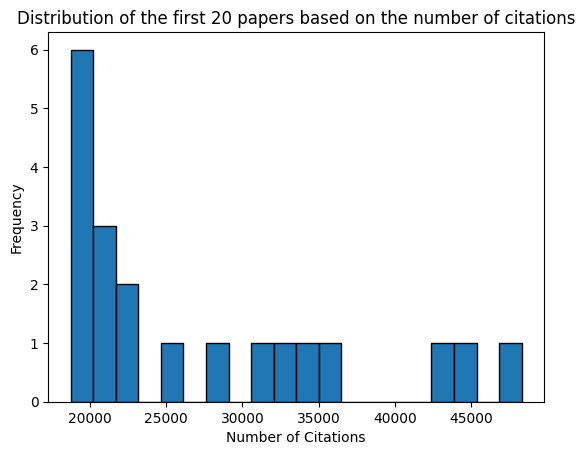

In [271]:
plt.hist(df['n_citation'][:20], bins=20, edgecolor='black')
plt.title(f'Distribution of the first 20 papers based on the number of citations')
plt.xlabel('Number of Citations')
plt.ylabel('Frequency')
plt.show()


##### Distribution of the papers based on the references count

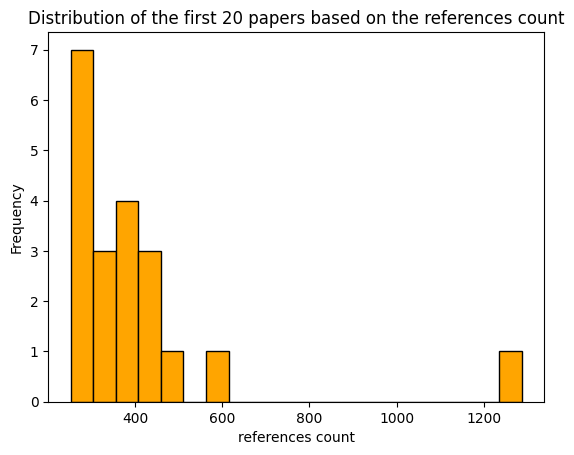

In [272]:
# plot the distribution of the first 20 papers based on the references count
df_ = df.sort_values(by='reference_count', ascending=False)
plt.hist(df_['reference_count'][:20], bins=20, edgecolor='black', color='orange')
plt.title(f'Distribution of the first 20 papers based on the references count')
plt.xlabel('references count')
plt.ylabel('Frequency')
plt.show()

**Note:** The dataframe was used to plot the distributions for simplicity since its the same data used to construct the graph.

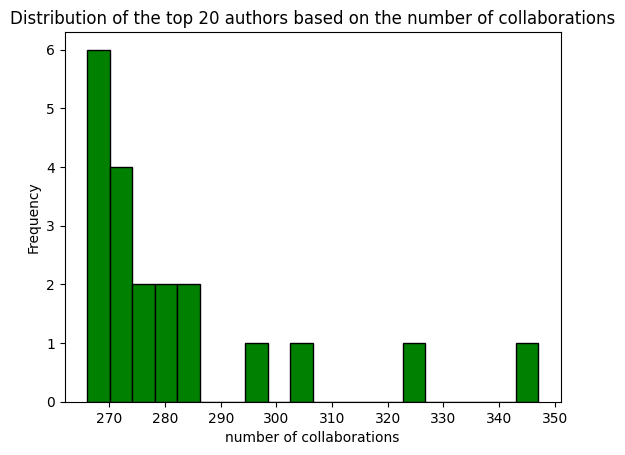

In [273]:
# Calculate node degrees
node_degrees = dict(collab_graph.degree())

# Sort nodes by degree in descending order
sorted_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)

# Extract the top 20 nodes and their degrees
top_nodes = sorted_nodes[:20]

# Plot the distribution
degrees = [degree for node, degree in top_nodes]

plt.hist(degrees, bins=20, edgecolor='black', color='green')
plt.title('Distribution of the top 20 authors based on the number of collaborations')
plt.xlabel('number of collaborations')
plt.ylabel('Frequency')
plt.show()

#### Visualization 2 - Visualize the node's contribution


In [299]:
def f2_visualize(graph, node, name_of_graph):
    """
    Visualizes Functionality #2 by printing the contribution of a specific node in the graph
    based on various centrality measures.

    Parameters:
    - graph: NetworkX graph
        The graph on which Functionality #2 is to be visualized.
    - node: int
        The node for which the contribution is to be visualized.
    - name_of_graph: str
        A string representing the name or identifier of the graph.

    Returns:
    None

    Prints:
    - Contribution of the specified node in the graph, including Betweenness Centrality,
      PageRank, Closeness Centrality, and Degree Centrality.

    Note:
    - The function internally uses another function 'f2_nodes_contribution' to calculate
      the contribution of the specified node based on various centrality measures.

    ```
    """
    # Calculate the contribution of the specified node using the internal function f2_nodes_contribution
    bc_node, pr_node, cc_node, dc_node = f2_nodes_contribution(graph, node, name_of_graph)

    # Display general information about the node using PrettyTable
    general_info = PrettyTable()
    general_info.title = f"Node {node} contribution in the {name_of_graph}"
    general_info.field_names = ["Betweenness Centrality", "PageRank", "Closeness Centrality", "Degree Centrality"]
    general_info.add_row([bc_node, pr_node, cc_node, dc_node])

    # Printing the PrettyTable containing the node's contribution
    print(general_info)


In [305]:
# example usage for the collaboration graph
f2_visualize(collab_graph, node = '163014821', name_of_graph = 'collaboration graph')

+-------------------------------------------------------------------------------------------------+
|                      Node 163014821 contribution in the collaboration graph                     |
+------------------------+-----------------------+------------------------+-----------------------+
| Betweenness Centrality |        PageRank       |  Closeness Centrality  |   Degree Centrality   |
+------------------------+-----------------------+------------------------+-----------------------+
| 8.250870430233785e-08  | 6.849168149974057e-05 | 0.00034678517300726965 | 0.0003296599792785156 |
+------------------------+-----------------------+------------------------+-----------------------+


#### Visualization 3 - Visualize the shortest-ordered route


In [336]:
def subgraph(graph):

    # number of nodes in the subgraph
    N = 1000
    nodes = list(graph.nodes())[:N]  
    subgraph = nx.Graph()  
    # Adds the subset_nodes to the subgraph
    subgraph.add_nodes_from(nodes)

    return subgraph
    

In [310]:
def f3_visualize(graph, mid_nodes, start_node, end_node, N):
    """
    Visualizes Functionality #3 by printing the papers crossed along the shortest-ordered route
    and creating a plot of the shortest-ordered route in the collaboration graph.

    Parameters:
    - graph: NetworkX graph
        The collaboration graph on which Functionality #3 is to be visualized.
    - mid_nodes: list of int
        The list of intermediate nodes through which the shortest-ordered route passes.
    - start_node: int
        The starting node of the route.
    - end_node: int
        The ending node of the route.
    - N: int
        The maximum number of papers to be considered.

    Returns:
    None

    Prints:
    - Table displaying the papers crossed along the shortest-ordered route.
    - Plot of the shortest-ordered route in the collaboration graph.

    Note:
    - The function internally uses another function 'f3_shortest_walk' to calculate
      the shortest-ordered route and the papers crossed along it.
    ```
    """
    # Calculate the shortest-ordered route and papers crossed along it using the internal function f3_shortest_walk
    shortest_walk, cross_papers = f3_shortest_walk(graph, mid_nodes, start_node, end_node, N)

    # Display the papers crossed along the shortest-ordered route using PrettyTable
    table = PrettyTable()
    table.title = 'Papers crossed along the shortest-ordered route'
    table.field_names = ["index", "paper id"]

    for i, paper_id in enumerate(shortest_walk):
        table.add_row([i+1, paper_id])

    print(table)
    print('\n')

    # Create a subgraph containing the nodes in the shortest walk
    subgraph_shortest_walk = graph.subgraph(shortest_walk)

    # Plot the shortest-ordered route using NetworkX and Matplotlib
    pos = nx.spring_layout(subgraph_shortest_walk)
    plt.figure(figsize=(8, 8))

    nx.draw(subgraph_shortest_walk, pos, with_labels=False, node_size=10, alpha=0.1)

    # Highlight nodes in the shortest walk
    nx.draw_networkx_nodes(subgraph_shortest_walk, pos, label=True, node_color='red', node_size=50)

    # Draw arrows between the nodes in the shortest walk and number them
    for i in range(len(shortest_walk)-1):
        plt.annotate(i+1, xy=pos[shortest_walk[i]], xytext=pos[shortest_walk[i+1]], 
                     arrowprops=dict(arrowstyle="->", color='blue', alpha=0.5, shrinkA=5, shrinkB=5, patchA=None, patchB=None, connectionstyle="arc3,rad=0.1"))

        # Adding shortest path node IDs
        plt.annotate(shortest_walk[i], xy=pos[shortest_walk[i]], xytext=pos[shortest_walk[i]], 
                     color='blue', alpha=0.5, size=5, weight='bold')

    # Add the title to the plot
    plt.title('Shortest-ordered route')

    # Display the plot
    plt.show()


+-------------------------------------------------+
| Papers crossed along the shortest-ordered route |
+----------------+--------------------------------+
|     index      |            paper id            |
+----------------+--------------------------------+
|       1        |           2065847026           |
|       2        |           173839695            |
|       3        |           1973035492           |
|       4        |           2034164144           |
|       5        |           1976452423           |
|       6        |           1973035492           |
|       7        |           2111642879           |
|       8        |           1973035492           |
|       9        |           2114532620           |
+----------------+--------------------------------+




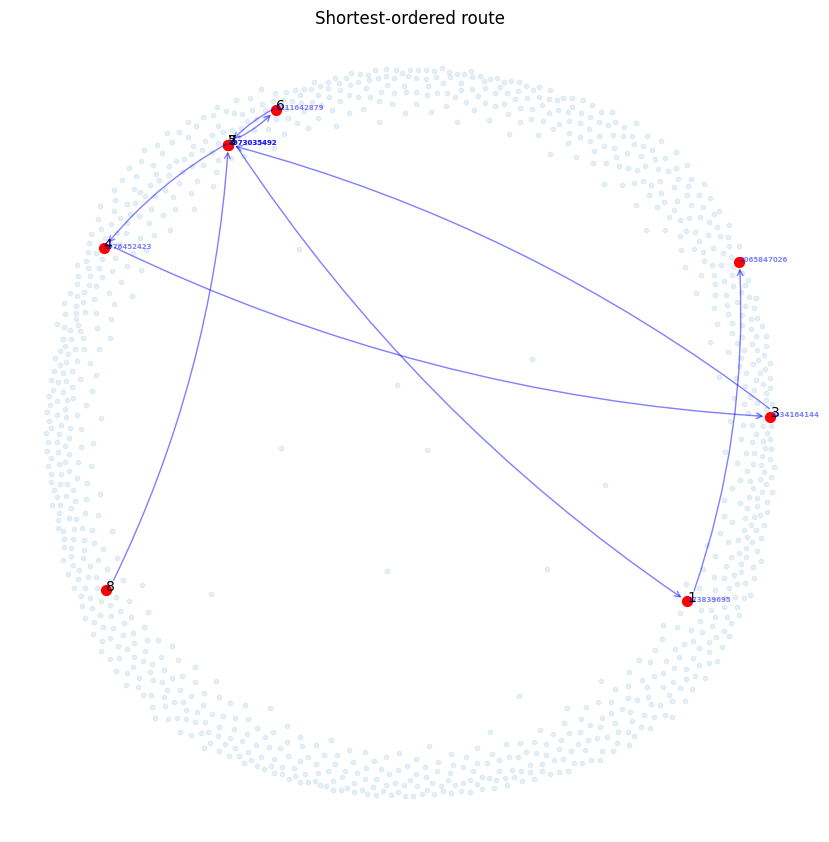

In [311]:
# Example usage for the citation graph
f3_visualize(collab_graph, ['173839695','2034164144','1976452423','2111642879'], '2065847026', '2114532620', 20)

#### Visualization 4 - Visualize the disconnected graph


In [351]:
def f4_visualize_orginal_graph(graph, authorA, authorB, N):
    """
    Visualizes Functionality #4 by displaying the original collaboration graph
    with highlighted nodes of two specified authors (authorA and authorB) and the
    minimum cut that disconnects the graph into two subgraphs.

    Parameters:
    - graph: NetworkX graph
        The collaboration graph on which Functionality #4 is to be visualized.
    - authorA: int
        The identifier of the first author.
    - authorB: int
        The identifier of the second author.
    - N: int
        The maximum number of edges to be considered for the minimum cut.

    Returns:
    None

    Prints:
    - The minimum number of edges required to disconnect the graph into two subgraphs.
    - Visualization of the original graph with highlighted nodes of authorA and authorB.

    Note:
    - The function internally uses another function 'f4_MinCut' to find the minimum cut
      and obtain two disconnected subgraphs.
      
    """
    # Find the minimum cut and disconnected subgraphs using the internal function f4_MinCut
    num_disconnect_edges, Ga, Gb, cut_weight = f4_MinCut(graph, authorA, authorB, N)
    print('The minimum number of edges required to disconnect the graph in two disconnected subgraphs:', num_disconnect_edges, '\n')

    # Create a subgraph containing nodes from both disconnected subgraphs
    original_graph = graph.subgraph(Ga.union(Gb))

    # Draw the original graph with highlighted nodes of authorA and authorB
    pos = nx.spring_layout(original_graph)
    plt.figure(figsize=(8, 8))

    # Draw nodes of authorA in red
    nx.draw_networkx_nodes(original_graph, pos, nodelist=Ga, node_color='red', node_size=50)

    # Draw nodes of authorB in blue
    nx.draw_networkx_nodes(original_graph, pos, nodelist=Gb, node_color='blue', node_size=50)

    # Draw the remaining nodes
    nx.draw_networkx_nodes(original_graph, pos, nodelist=set(original_graph.nodes) - Ga - Gb, node_size=10, alpha=0.1)

    # Draw edges
    nx.draw_networkx_edges(original_graph, pos, alpha=0.1)

    # Highlight the minimum cut edges
    cut_edges = [(u, v) for u, v in graph.edges if u in Ga and v in Gb]
    nx.draw_networkx_edges(original_graph, pos, edgelist=cut_edges, edge_color='black', width=2)

    # Add labels for authorA and authorB
    nx.draw_networkx_labels(original_graph, pos, labels={authorA: authorA, authorB: authorB}, font_size=10, font_color='black')

    # Add the title to the plot
    plt.title('Original Graph with Minimum Cut')

    # Display the plot
    plt.show()


The minimum number of edges required to disconnect the graph in two disconnected subgraphs: 4 



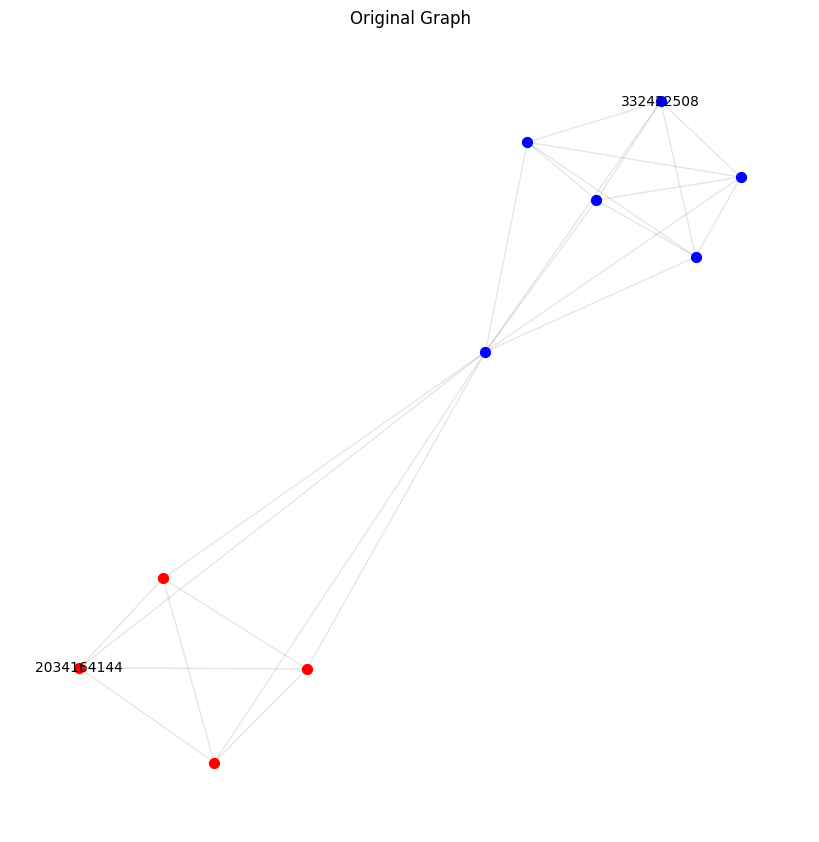

In [352]:
# example usage for the collaboration graph
authorA = '2034164144'
authorB = '332422508'

f4_visualize_orginal_graph(collab_graph, authorA, authorB, N = 10)

In [365]:
def f4_visualize_disconnected_graph(graph, authorA, authorB, N):
    """
    Visualizes Functionality #4 by displaying the graph after disconnecting the two subgraphs
    formed by the minimum cut, with highlighted nodes of authorA and authorB.

    Parameters:
    - graph: NetworkX graph
        The collaboration graph on which Functionality #4 is to be visualized.
    - authorA: int
        The identifier of the first author.
    - authorB: int
        The identifier of the second author.
    - N: int
        The maximum number of edges to be considered for the minimum cut.

    Returns:
    None

    Prints:
    - Visualization of the graph after disconnecting the two subgraphs formed by the minimum cut.
      Nodes of authorA and authorB are highlighted.

    Note:
    - The function internally uses another function 'f4_MinCut' to find the minimum cut
      and obtain two disconnected subgraphs.
    """
    # Find the minimum cut and disconnected subgraphs using the internal function f4_MinCut
    num_disconnect_edges, Ga, Gb, cut_weight = f4_MinCut(graph, authorA, authorB, N)
    
    # Create a subgraph containing nodes from both disconnected subgraphs
    original_graph = graph.subgraph(Ga.union(Gb))

    # Create a copy of the original graph
    disconnected_graph = original_graph.copy()

    # Disconnect the two subgraphs formed by the minimum cut
    for u, v in disconnected_graph.edges():
        if (u in Ga and v in Gb) or (u in Gb and v in Ga):
            disconnected_graph.remove_edge(u, v)

    # Draw the disconnected graph with highlighted nodes of authorA and authorB
    pos = nx.spring_layout(disconnected_graph)
    plt.figure(figsize=(8, 8))

    # Draw nodes of authorA in red
    nx.draw_networkx_nodes(disconnected_graph, pos, nodelist=[authorA], node_color='red', node_size=50)

    # Draw nodes of authorB in blue
    nx.draw_networkx_nodes(disconnected_graph, pos, nodelist=[authorB], node_color='blue', node_size=50)

    # Draw the remaining nodes
    nx.draw_networkx_nodes(disconnected_graph, pos, nodelist=set(disconnected_graph.nodes) - {authorA, authorB}, node_size=10, alpha=0.1)

    # Draw edges
    nx.draw_networkx_edges(disconnected_graph, pos, alpha=0.1)

    # Add labels for authorA and authorB
    nx.draw_networkx_labels(disconnected_graph, pos, labels={authorA: authorA, authorB: authorB}, font_size=10, font_color='black')

    # Add the title to the plot
    plt.title('Disconnected Graph after Minimum Cut')

    # Display the plot
    plt.show()


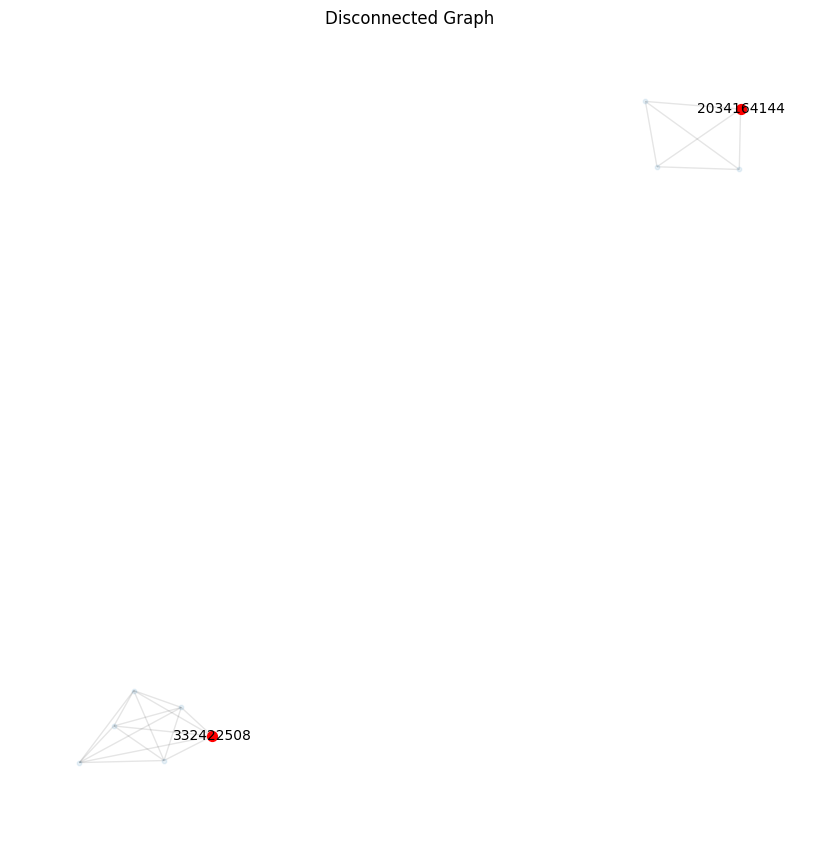

In [366]:
# example usage
f4_visualize_disconnected_graph(collab_graph, authorA, authorB, N = 10)

#### Visualization 5 - Visualize the communities


In [390]:
def f5_visualize(graph, paper_1, paper_2, N):
    """
    Visualizes Functionality #5 by displaying the graph after extracting communities and highlighting
    the nodes of two specified papers (paper_1 and paper_2). Also, prints the communities and the number
    of edges to cut to disconnect the graph into two subgraphs.

    Parameters:
    - graph: NetworkX graph
        The collaboration graph on which Functionality #5 is to be visualized.
    - paper_1: int
        The identifier of the first paper.
    - paper_2: int
        The identifier of the second paper.
    - N: int
        The maximum number of edges to be considered for community extraction.

    Returns:
    None

    Prints:
    - The number of edges to cut to disconnect the graph into two subgraphs.
    - Table displaying the communities and their papers.
    - Visualization of the graph with highlighted nodes of paper_1 and paper_2.

    Note:
    - The function internally uses another function 'f_5_Community_Extraction' to find the communities
      and obtain the subgraph with highlighted nodes.
    
    """
    # Extract communities and obtain relevant information using the internal function f_5_Community_Extraction
    num_edges_to_cut, communities, same_community, subgraph_new = f_5_Community_Extraction(graph, paper_1, paper_2, N)

    # Print the number of edges to cut
    print('The number of edges to cut to disconnect the graph in two disconnected subgraphs:', num_edges_to_cut, '\n')

    # Create a PrettyTable for displaying communities and their papers
    communities_table = PrettyTable()
    communities_table.title = 'Communities'
    communities_table.field_names = ["Community", "Papers"]

    for i, community in enumerate(communities):
        communities_table.add_row([i+1, community])

    print(communities_table)
    print('\n')

    # Draw the graph with highlighted nodes of paper_1 and paper_2
    pos = nx.spring_layout(subgraph_new)
    plt.figure(figsize=(8, 8))

    # Draw nodes of paper_1 and paper_2 in red
    nx.draw_networkx_nodes(subgraph_new, pos, nodelist=[paper_1, paper_2], node_color='red', node_size=50)

    # Draw the remaining nodes
    nx.draw_networkx_nodes(subgraph_new, pos, nodelist=set(subgraph_new.nodes) - {paper_1, paper_2}, node_size=10, alpha=0.1)

    # Draw edges
    nx.draw_networkx_edges(subgraph_new, pos, alpha=0.1)

    # Add labels for paper_1 and paper_2
    nx.draw_networkx_labels(subgraph_new, pos, labels={paper_1: paper_1, paper_2: paper_2}, font_size=10, font_color='black')

    # Add the title to the plot
    plt.title('Original Graph with Highlighted Papers')

    # Display the plot
    plt.show()


The number of edges to cut to disconnect the graph in two disconnected subgraphs: 1 

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                            Communities                                                                                             |
+-----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Community |                                                                                         Papers                                                                                         |
+-----------+---------------------------------------------------------------------------------------------------------

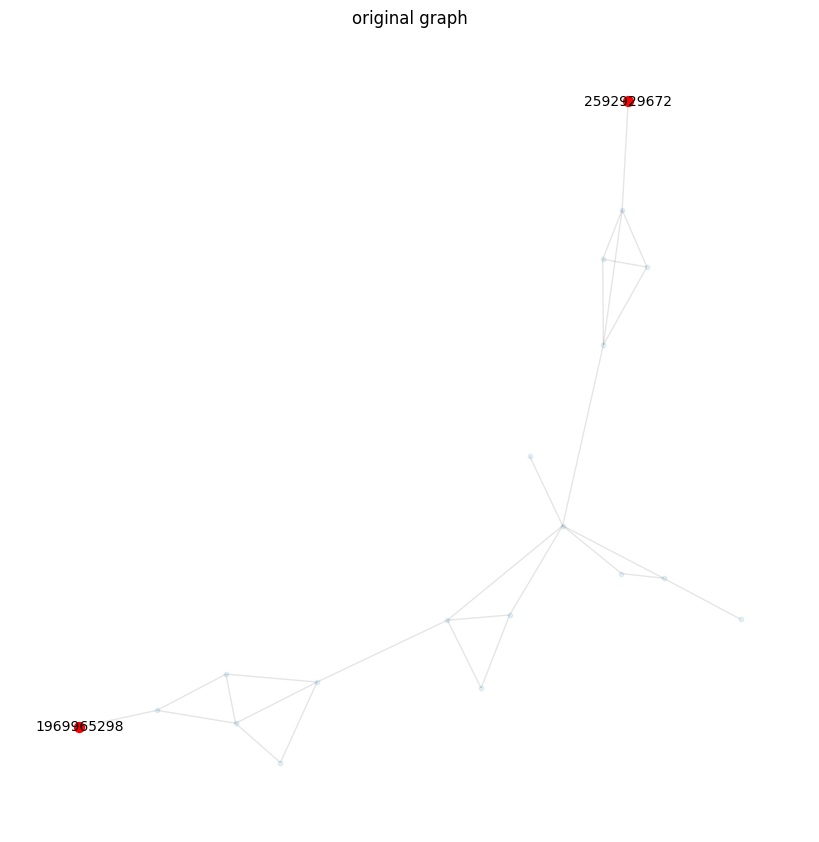

In [391]:
#example usage for the citation graph
paper_1 = '1969965298'
paper_2 = '2592929672'
f5_visualize(citation_graph, paper_1, paper_2, 100)

In [400]:
def f5_visualize_communities(graph, paper_1, paper_2, N):
    """
    Visualizes Functionality #5 by displaying the graph after extracting communities and
    highlighting the nodes of the specified papers (paper_1 and paper_2) within their communities.
    Also, adds a color legend for each community.

    Parameters:
    - graph: NetworkX graph
        The collaboration graph on which Functionality #5 is to be visualized.
    - paper_1: int
        The identifier of the first paper.
    - paper_2: int
        The identifier of the second paper.
    - N: int
        The maximum number of edges to be considered for community extraction.

    Returns:
    None

    Prints:
    - Visualization of the graph with highlighted nodes of paper_1 and paper_2 within their communities.
      Also, adds a color legend for each community.

    Note:
    - The function internally uses another function 'f_5_Community_Extraction' to find the communities
      and obtain the subgraph with highlighted nodes.

    """
    # Extract communities and obtain relevant information using the internal function f_5_Community_Extraction
    num_edges_to_cut, communities, same_community, subgraph_new = f_5_Community_Extraction(graph, paper_1, paper_2, N)

    # Draw the graph with highlighted nodes of paper_1 and paper_2 within their communities
    pos = nx.spring_layout(subgraph_new)
    plt.figure(figsize=(8, 8))

    # Draw nodes of paper_1 and paper_2 in red
    nx.draw_networkx_nodes(subgraph_new, pos, nodelist=[paper_1, paper_2], node_color='red', node_size=50)

    # Draw the remaining nodes
    nx.draw_networkx_nodes(subgraph_new, pos, nodelist=set(subgraph_new.nodes) - {paper_1, paper_2}, node_size=10, alpha=0.1)

    # Draw edges
    nx.draw_networkx_edges(subgraph_new, pos, alpha=0.1)

    # Highlight communities in different colors
    colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'grey', 'black']
    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(subgraph_new, pos, nodelist=community, node_color=colors[i], node_size=50)

    # Add labels for paper_1 and paper_2
    nx.draw_networkx_labels(subgraph_new, pos, labels={paper_1: paper_1, paper_2: paper_2}, font_size=10, font_color='black')

    # Add the title to the plot
    plt.title('Graph with Highlighted Papers within Communities')

    # Add color legend for each community
    plt.legend([f'Community {i+1}: {colors[i]}' for i in range(len(communities))])

    # Display the plot
    plt.show()


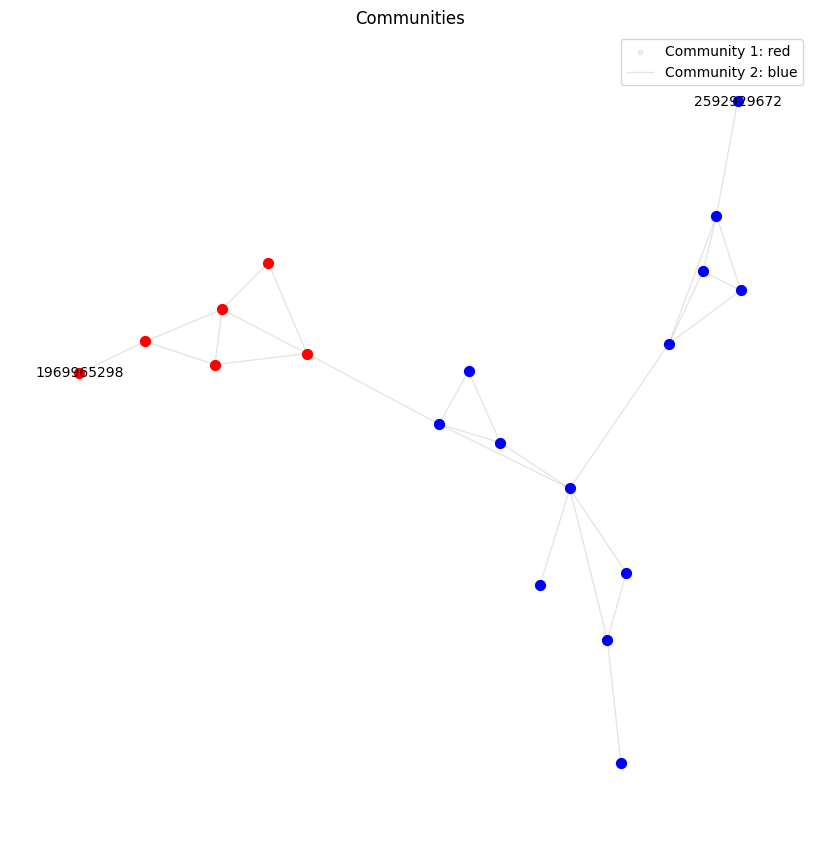

In [401]:
# example usage for the citation graph

paper_1 = '1969965298'
paper_2 = '2592929672'
f5_visualize_communities(citation_graph, paper_1, paper_2, 100)

In [402]:
def f5_visualize_disconnected_communities(graph, paper_1, paper_2, N):
    """
    Visualizes Functionality #5 by displaying the graph after extracting communities and disconnecting
    the two subgraphs formed by the minimum cut, with highlighted nodes of the specified papers (paper_1
    and paper_2) within their communities. Also, adds a color legend for each community.

    Parameters:
    - graph: NetworkX graph
        The collaboration graph on which Functionality #5 is to be visualized.
    - paper_1: int
        The identifier of the first paper.
    - paper_2: int
        The identifier of the second paper.
    - N: int
        The maximum number of edges to be considered for community extraction.

    Returns:
    None

    Prints:
    - Visualization of the graph after disconnecting the two subgraphs formed by the minimum cut.
      Nodes of paper_1 and paper_2 are highlighted within their communities, and a color legend is added.

    Note:
    - The function internally uses another function 'f_5_Community_Extraction' to find the communities
      and obtain the subgraph with highlighted nodes.
    """
    # Extract communities and obtain relevant information using the internal function f_5_Community_Extraction
    num_edges_to_cut, communities, same_community, subgraph_new = f_5_Community_Extraction(graph, paper_1, paper_2, N)

    # Create a copy of the subgraph to disconnect the two subgraphs formed by the minimum cut
    disconnected_graph = subgraph_new.copy()

    # Disconnect the two subgraphs formed by the minimum cut
    for u, v in disconnected_graph.edges():
        if (u in communities[0] and v in communities[1]) or (u in communities[1] and v in communities[0]):
            disconnected_graph.remove_edge(u, v)

    # Draw the disconnected graph with highlighted nodes of paper_1 and paper_2 within their communities
    pos = nx.spring_layout(disconnected_graph)
    plt.figure(figsize=(8, 8))

    # Draw nodes of paper_1 and paper_2 in red
    nx.draw_networkx_nodes(disconnected_graph, pos, nodelist=[paper_1, paper_2], node_color='red', node_size=50)

    # Draw the remaining nodes
    nx.draw_networkx_nodes(disconnected_graph, pos, nodelist=set(disconnected_graph.nodes) - {paper_1, paper_2}, node_size=10, alpha=0.1)

    # Draw edges
    nx.draw_networkx_edges(disconnected_graph, pos, alpha=0.1)

    # Highlight communities in different colors
    colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'grey', 'black']
    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(disconnected_graph, pos, nodelist=community, node_color=colors[i], node_size=50)

    # Add labels for paper_1 and paper_2
    nx.draw_networkx_labels(disconnected_graph, pos, labels={paper_1: paper_1, paper_2: paper_2}, font_size=10, font_color='black')

    # Add the title to the plot
    plt.title('Disconnected Communities with Highlighted Papers')

    # Add color legend for each community
    plt.legend([f'Community {i+1}: {colors[i]}' for i in range(len(communities))])

    # Display the plot
    plt.show()


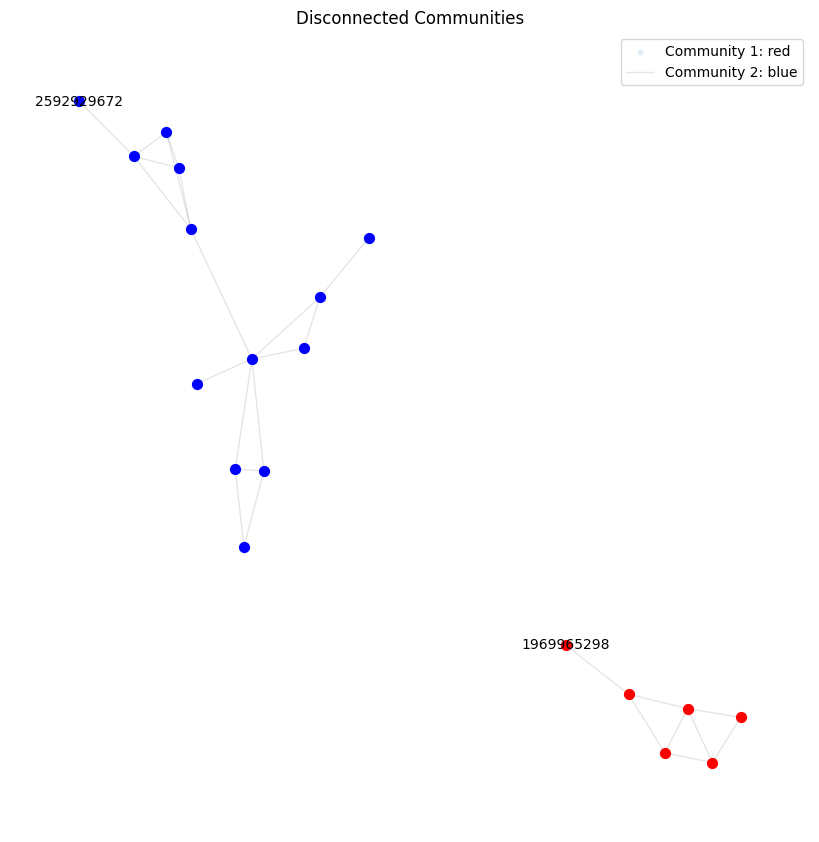

In [403]:
# example usage for the citation graph
paper_1 = '1969965298'
paper_2 = '2592929672'
f5_visualize_disconnected_communities(citation_graph, paper_1, paper_2, 100)

### Algorithmic Question

#### Part A

##### 1.

In [ ]:
def calculate_max_score(N, M, S, required_skills, athletes):

    # create an empty dictionary
    # the skills are going to be the keys of the dictionary and the values are going to be a list of tuples
    # where each tuple represent an athlete and his score relative to the specific key (the skill)
    
    skills_athletes = {}         
    for athlete in athletes:      
        id = athlete[0]
        for skill, score in athlete[1:]:
            if skill not in skills_athletes:
                skills_athletes[skill] = []
            skills_athletes[skill].append((score, id))

    # sort athletes for each skill based on their proficiency
    
    for skill in skills_athletes:   
        skills_athletes[skill].sort(reverse=True)   

    # selecting athletes for the team
    
    team = {}  # O(1)
    for skill in required_skills:
        # check if the skill in required skills is actually in our dictionary of skills
        if skills_athletes[skill]: 
        # select the athlete with the highest score who hasn't been selected yet
            for score, id in skills_athletes[skill]:
                if id not in team:
                    team[id] = score
                    break

    # calculating total score
    total_score = sum(team.values())
    return total_score

N, M, S = 14, 10, 2
required_skills = ["SWM", "VOL", "ATH", "VOL", "VOL", "BSK", "HCK", "BSK", "SWM", "BSK"]
athletes = [
    [1, ("BSK", 98), ("HCK", 12)],
    [2, ("ATH", 14), ("VOL", 1)],
    [3, ("HCK", 82), ("ATH", 30)],
    [4, ("HCK", 9), ("SWM", 27)],
    [5, ("FTB", 90), ("HCK", 50)],
    [6, ("ATH", 52), ("RGB", 80)],
    [7, ("HCK", 95), ("SWM", 11)],
    [8, ("TEN", 85), ("RGB", 7)],
    [9, ("RGB", 46), ("SWM", 30)],
    [10, ("SWM", 16), ("BSK", 12)],
    [11, ("VOL", 32), ("HCK", 40)],
    [12, ("SOC", 41), ("FTB", 12)],
    [13, ("SWM", 59), ("TEN", 82)],
    [14, ("SWM", 34), ("VOL", 20)]
]

In [ ]:
calculate_max_score(N, M, S, required_skills, athletes)

399

A second implementation of the algorithm which could be more efficient. 

The main difference is that the first algorithm uses lists and sorts them while the second one uses heaps to retrieve the top element

In [ ]:
from collections import defaultdict
import heapq

def calculate_max_score_heap_defaultdict(N, M, S, required_skills, athletes):
    
    skill_to_athletes = defaultdict(list)
    for athlete in athletes:
        id = athlete[0]
        for skill, score in athlete[1:]:
            heapq.heappush(skill_to_athletes[skill], (-score, id))

    team = {}
    for skill in required_skills:
        while skill_to_athletes[skill]:
            score, id = heapq.heappop(skill_to_athletes[skill])
            if id not in team:
                team[id] = -score
                break

    return sum(team.values())

N, M, S = 14, 10, 2
required_skills = ["SWM", "VOL", "ATH", "VOL", "VOL", "BSK", "HCK", "BSK", "SWM", "BSK"]
athletes = [
    [1, ("BSK", 98), ("HCK", 12)],
    [2, ("ATH", 14), ("VOL", 1)],
    [3, ("HCK", 82), ("ATH", 30)],
    [4, ("HCK", 9), ("SWM", 27)],
    [5, ("FTB", 90), ("HCK", 50)],
    [6, ("ATH", 52), ("RGB", 80)],
    [7, ("HCK", 95), ("SWM", 11)],
    [8, ("TEN", 85), ("RGB", 7)],
    [9, ("RGB", 46), ("SWM", 30)],
    [10, ("SWM", 16), ("BSK", 12)],
    [11, ("VOL", 32), ("HCK", 40)],
    [12, ("SOC", 41), ("FTB", 12)],
    [13, ("SWM", 59), ("TEN", 82)],
    [14, ("SWM", 34), ("VOL", 20)]
]

In [ ]:
calculate_max_score_heap_defaultdict(N, M, S, required_skills, athletes)

399

##### 2. What is the time complexity (the Big O notation) of your solution? Please provide a detailed explanation of how you calculated the time complexity.

The time complexity of the algorithm is O(K * A * log(A)) since it's the dominant term. 
The time complexity of creating and empty dictionary is O(1). The first for loop iterates over N athletes so the time complexity is O(N) and the nested for loop iterates S skills of athletes, so the time complexity of these for loops is going to be O(N * S). The check, creating a list and appending elements to a list all have comlexity O(1). 
The time complexity of the second for loop is O(K * A * log(A)), where K is the number of keys of the dictionary skills_athletes and A * log(A) is time complexity of the sort algorithm used in Python (A is the length of the list, which in our case may vary).
Finally, the time complexity of the third algorithm is O(M * N), since the outer loop iterates over the required skills list (O(M)) and the inner one iterates over the list of tuples for each skill, so it depends on the length of the list, but in the worse case it's going to be N


##### 3. Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Compare your answer to theirs. If the two differ, which one is right? (why?)

The time complexity of the calculate_max_score function can be analyzed as follows: 
The first nested loop iterates over each athlete and their skills, with N representing the number of athletes and each athlete having up to M skills. This results in a time complexity of O(N * M) for this part, as it essentially processes each skill of each athlete. 
The second loop sorts the athletes for each skill. Assuming the worst case where each athlete has a unique skill, this sorting step would be O(N log N) for each skill, and since there are up to M skills, the complexity is O(M * N log N). However, in practice, the number of athletes per skill is likely less than N, possibly making this step less costly. 
The third loop iterates over the required skills (S in total) and selects an athlete for each skill. In the worst case, this could iterate over all athletes for each skill, leading to a complexity of O(S * N). Lastly, summing the team's values is O(N) in the worst case. Combining these, the dominant term is O(M * N log N) from the sorting step, followed by O(N * M) and O(S * N). The overall time complexity is O(M * N log N), assuming M, N, and S are of the same order of magnitude.

Actually, the two analysis are similar. ChatGPT is not always giving the correct name to some variables but it's comprehensible. 

##### 4. If you algorithm has exponential time complexity, can you provide a polynomial-time version?

Our algorithm is already in polynomial-time

##### 5. If S=1, how does the time complexity of an optimal algorithm to solve this problem change?

Considering our algorithm, the time complexity if S=1 wouldn't change since it only impacts the first loop, where we have a time complexity of O(N * S)

#### Part B 

##### 1. Prove or disprove that the problem is NP-complete.

A problem P is considered NP-complete if:
- P is in NP (we can verify in polynomial time whether the solution is correct or not)
- P is NP-hard (any problem in NP can be reduced to P in polynomial time)

Let's start by proofing that P is in NP:

We need to verify:
1. that all required skills in T are covered in the union of the skills of the athletes
2. that the sum of the weights of the edges in Ec(V') is the one that minimizes the effort to work together.

To verify the first condition, we need to check the set of skills of all the individuals belonging to V' with T. The time complexity for this verification can be represented as O(V' * S + T), where V' is the number of athletes in the subset and S is the number of skills per athlete, so we can say it is clearly polynomial.

To verify the second condition, instead, there are several algorithms that compute the minimum spanning tree. One of these is the Kruskal's Algorithm, which has time complexity O(E * log E), so it has polynomial time.


Now let's prove that the problem is NP-hard:

To do so, we need to reduce a known NP-complete problem to our problem. Of the problems we saw in class, the most similar ones we thought could fit our problem were the Set Cover problem and the Traveling Salesman Problem. We decided to proceed with the Set Cover one.
Sets in the Set Cover problem may correspond to an athlete in our problem. The elements that the set contains may correspond to the athlete's skills. The universe may correspond to the set T of required skills.
For the reduction (converting the problem to our problem), we assume that all individuals can work together with the same effort, meaning we can set the edge weights in the graph to a constant value.
The goal is now to find a subset V' that covers all skills in T (analogous to covering the universe with a subset of sets) and has the minimum total effort (which is trivially minimized when all weights are equal, and the graph is connected).

Given this reduction, any solution to the Set Cover problem can be used to find a solution to our team formation problem by constructing the corresponding graph and selecting the subset V'. As we saw, the reduction can be done in polynomial time since it involves a simple one-to-one mapping of elements between the two problems.

Since we can reduce the Set Cover problem to our problem in polynomial time, and since Set Cover is NP-complete, our problem is at least as hard as Set Cover. Therefore, our problem is NP-hard.

We have now proved that the problem is both in NP and is NP-hard, so we can state that our problem P is NP-complete.



##### 2. Write a heuristic in order to approximate the best solution for this problem.

We initialize an empty subset V' representing the team. We create a list that keeps track of the required skills that are not yet covered by V'. For each individual in V we calculate their contribution to the team, which in our case will be the skills they would add to the team's skill coverage (we will only consider useful the skills which are included in the set T) and the effort score with the existing team members to which they are connected to. We need to select the team members. To do so, we iterate over all athletes not yet in V', which at the beginning is empty so we'll have to iterate over all of the athletes. For each athlete, we calculate their contribution to the skill coverage and the incremental effort of adding them to the team. Of course, at the first iteration, whichever athlete (node) we pick will not increase the team's total effort since that depends on the way in which nodes are connected. So after the first iteration where we will pick the athlete that adds most new skills, we'll also look at the ones that results in the least increase in the team's total effort and add the selected individual to V', so here we'll have to sort individuals which are not yet in V' and pick the one with the best score (where score, as previously said, is calculated based on useful skills he's adding and effort he adds to the team). We can assume that every node is connected with all of the nodes, so this simplifies the process since we do not have to think at which nodes we need in order to have them all connected. For each iteration we then update the list of uncovered skills and compute the minimum spanning tree. The selection process is repeated until all required skills are covered. 
Finally, we have to return the final subset V' and the corresponding MST as the approximate best solution.

##### 3. What is the time complexity of your solution ?

To compute the time complexity, we need to look at which actions are performed. We need to iterate over all nodes, so this will be a linear operation which will depend on the number N of athletes. Then we have to compute their score (compute new skills that athlete can contribute, so O(S)), sort them based on their score, which as we saw in part A takes time O(N * log N) and compute the MST which with Kruskal's algorithm is O(E * log E). So the final time complexity is O(N * S) + O(N * log N) + O(E * log E)

### 4. Command Line Question (CLQ)

#### 1. Is there any node that acts as an important "connector" between the different parts of the graph?


To determine whether a node is a significant "connector" between different parts of the graph, here is a useful measure:

- **Degree Centrality**: The degree centrality of a node is the ratio of its total degree to the total number of nodes in the graph.

We subsequently present the nodes corresponding to the highest values of the measure:
- Node: 47957325, with degree centrality: 0.01276064130402451

#### 2. How does the degree of citation vary among the graph nodes?

To describe the distribution of degrees in the citation graph, we need to consider three types of degrees:
- **IN-degree**: The number of edges entering a node in a directed graph
- **OUT-degree**:  The number of edges leaving a node in a directed graph
- **TOTAL degree**: The sum of the *IN-degree* and *OUT-degree* 

In particular, we identify the top three nodes with the highest total degree values, along with their respective degree values:

- Node with the **highest degree** value: ('47957325', 1287)
- Node with the **second highest** degree value: ('2076063813', 564)
- Node with the **third highest** degree value: ('2148043549', 489)

After examining the total degrees of the nodes, we then focus primarily on the *IN* and *OUT* degrees. Here are the highest *IN* and *OUT* degree values:
- Node with the **highest in-degree**: 2151103935, with an *in-degree* of 131 and an *out-degree* of 33
- Node with the **highest out-degree**: 47957325, with an *in-degree* of 0 and an *out-degree* of 1287. It is also the highest total degree node and it seems to only have nodes going out from it

Finally, in order to have a general view of the degrees of the nodes we calculated some degrees statistics according to the diffent types of degrees ( *TOTAL*, *IN*, *OUT*).
In the results we can easily see that:
- Regarding the **TOTAL-degree distribution**: the average degree of the nodes is approximately 3.7351 and, considering the median (which is less influenced by outliers than the mean) and the quartiles, most of the nodes have a degree that is lower than 2.
- Regarding the **IN-degree distribution**: as before, most of the nodes have an *IN-degree* lower than 2.
- Regarding the **OUT-degree distribution**: there are at least the 75% of the nodes that do not have edges leaving them. There is one strong outlier which is the one mentioned before with a *OUT-degree* of 1287

#### 3. What is the average length of the shortest path among nodes?

Initially, we identify all the isolated nodes within the graph and remove them, as they are not beneficial for answering the question and do not contribute to the overall structure of the graph. 
- Number of **isolated nodes** deleted: 324

Lately, we also checked the total number of strongly connected components, as this will serve as a basis for calculating the average length.
- Number of **strongly connected components**:  100007. Given that this number is very high, it indicates that our citation graph is highly disconnected.

Subsequently, we decided to quickly analyze the strongly connected components to get a general overview. It is possible to note that:

- There are 56 nodes in the **largest** strongly connected component, with an average degree of 49.1964 and a maximum degree of 198.
- There are 39 nodes in the **second largest** strongly connected component, with an average degree of 22.1282 and a maximum degree of 111.
- There are 23 nodes in the **third largest** strongly connected component, with an average degree of 42.3043 and a maximum degree of 132.


From these observations, we can conclude that our graph is well interconnected, with a medium proportion of nodes being part of strongly connected components. This suggests that part of the nodes in our graph tend to form tightly knit groups, where almost every pair of nodes is mutually reachable. 

Later, we define only the components made of more than one node so that components can have an actual path within them, making it meaningful to talk about the shortest path. As a result, we have identified 252 strongly connected components (**SCCs**) that contain more than one node and thus have paths within them. SCCs represent subsets of nodes in the graph where each node is reachable from every other node within the subset.

Finally, we calculate the average length of the shortest path of the nodes in the different components:
- **Average** shortest path length: 1.1580115477923858

Additionally, we computed other statistics about the distribution of the shortest path length across these components:
- **Minimum** shortest path length: 1.0
- **Maximum** shortest path length: 4.33794466403162
- **1st Quartile**: 1.0
- **3rd Quartile**: 1.1666666666666667

In conclusion, the analysis shows that while the graph has a large number of components, a fewer portion of these (252 out of approximately 100,000) contain more than one node. On average, it takes about 1.16 steps to travel from one node to another within these strongly connected components. The data also suggests a relatively uniform distribution of shortest path lengths, with both the first and third quartiles being close to 1.0. 


![Local Image](./clq.jpg)
